## _______________________




# <span style="color:pink"> Trabajo Práctico 4 - Big Data </span>


_______________________

<span style="color:#581845">***Regularización aplicada a la EPH*** 
</span>


<span style="color:#C70039">Abigail Riquelme
</span>


### Parte I: Análisis de la base de hogares y cálculo de pobreza

In [483]:
# Código para mostrar el codigo. La fuente es la siguiente: https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer


import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')

#### Importamos los módulos necesarios

In [1]:
import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt  # Para matriz de correlaciones
import statsmodels.api as sm     
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import plot_roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import expit
from sklearn.model_selection import KFold

#### Pasos previos 

In [2]:
# Definimos el directorio de trabajo 
directorio_tp="C:\\Users\\Abi\\Documents\\GitHub\\TrabajosPracticos-Grupo8\\TP2"

In [3]:
import os

# Modificamos el directorio de trabajo
os.chdir(directorio_tp) 

# Verificamos que el directorio sea el correcto
os.getcwd()

'C:\\Users\\Abi\\Documents\\GitHub\\TrabajosPracticos-Grupo8\\TP2'

#### 1) 

In [4]:
import pandas as pd
eph_2021=pd.read_excel('usu_hogar_T121.xlsx')

In [5]:
# Descarguen la base de microdatos de la EPH correspondiente al primer tri-
# mestre de 2021 (la base de hogares se llama usu_hogar_T121.xls). Importen
# los datos de la encuesta de hogar y al igual que en el TP1 conserven sólo las
# observaciones que corresponden a los aglomerados de Ciudad Autónoma
# de Buenos Aires o del Gran Buenos Aires.


# Abrimos la base de datos, la llamaremos eph_2021:
eph_2021=pd.read_excel('usu_hogar_T121.xlsx')

In [6]:
# Eliminamos todas las observaciones que no corresponden a los aglomerados de Ciu-
# dad Autónoma de Buenos Aires o Gran Buenos Aires.
eph_2021 = eph_2021[eph_2021.REGION == 1]

In [7]:
len(eph_2021)

1474

#### 2) 

In [8]:
# Unan la tabla de la encuesta individual con la de la encuesta de hogar.

# Para esto, importamos los datos de la encuesta individual. Abrimos la base de datos, la llamaremos eph_2021_ind:

eph_2021_ind = pd.read_excel('usu_individual_T121.xlsx')

In [9]:
len(eph_2021_ind)

46693

In [10]:
# Eliminamos todas las observaciones que no corresponden a los aglomerados de Ciu-
# dad Autónoma de Buenos Aires o Gran Buenos Aires.

eph_2021_ind = eph_2021_ind[eph_2021_ind.REGION == 1]

In [11]:
# Unimos la tabla de la encuesta individual con la de la encuesta de hogar 
eph_final = pd.merge(eph_2021_ind, eph_2021, how='left', on=['CODUSU', 'NRO_HOGAR'])

In [12]:
len(eph_final)

4082

#### 3) 

Con el objetivo de limpiar la base de datos utilizaremos las funciones SimpleImputer,
fit y transform para las variables no categóricas, todas disponibles en el paquete
sklearn.impute. La función fit lo que hace es coloque el imputador en la base a la
que le aplicamos la función y transform imputa todos los valores faltantes en la base
de datos.

Para las variables categóricas utilizaremos la función fillna y get_dummies, ambas del
paquete Pandas.


In [13]:
# Observamos el tipo de cada columna de la matriz, es decir, de cada variable 
tipos=eph_final.dtypes

print(tipos)

CODUSU         object
ANO4_x          int64
TRIMESTRE_x     int64
NRO_HOGAR       int64
COMPONENTE      int64
                ...  
VII1_2          int64
VII2_1          int64
VII2_2          int64
VII2_3          int64
VII2_4          int64
Length: 263, dtype: object


###### Tratamiento de los missings de variables categóricas 

In [14]:
# Para tratar los missing de las variables categóricas les asignaremos un valor igual a -1 para de esta forma 
# tener información sobre las personas que no respondieron. Decidimos seguir este enfoque debido a que 
# en algunos casos puede ser útil contar con dicha información. 



In [15]:
# Es importante aclarar que aquellas variables más técnicas, es decir, aquellas que nos permiten identificar a los hogares las pondremos, por el momento, en un base de datos aparte. Luego, 
# uniremos las bases de datos con variables categóricas, no categóricas junto con la base de datos de variables técnicas: 

eph_tecnicas=eph_final.loc[:,['TRIMESTRE_x', 'NRO_HOGAR','CODUSU', 'COMPONENTE', 'H15', 'REGION_x', 'AGLOMERADO_x', 'PONDERA_x','PONDIH_x']]

In [16]:
# Además, para tratar los missing de las variables categóricas eliminamos las variables no categóricas. 
# Posterior a esto uniremos las dos bases resultantes del tratado de los datos missing. Notar que a continuación eliminamos todas las variables no categóricas y además 
# aquellas categóricas que tienen un porcentaje de datos missing mayor al 80%.

# En la lista de variables categóricas que usaremos no consideraremos a aquellas referidas a la pertenencia al decil 


eph_categoricas= eph_final.drop(['CODUSU', 'CH05','MAS_500_x','ANO4_x','MAS_500_y','IDECOCUR', 'IDECIFR_y', 'PP09C_ESP', 
                                 'PP09A_ESP', 'IDECCFR_y', 'PDECOCUR', 'PDECCFR_y', 'IDECINDR', 'II8_ESP', 'PDECINDR', 
                                 'II7_ESP', 'IV7_ESP', 'IV3_ESP', 'IV1_ESP', 'PDECIFR_y', 'IMPUTA', 'CH16_COD', 
                                 'PP11D_COD', 'PP11C', 'PP11C99', 'PP11B2_DIA', 'PP11B2_MES', 'PP11B2_ANO', 
                                 'PP11T', 'PP11B_COD', 'PP11A', 'PP10E', 'PP10D', 'PP10C', 'PP10A', 'PP11B1', 
                                 'PP11G_ANO', 'PP11N', 'PP11G_MES', 'PP11S', 'PP11R', 'PP11Q', 'PP11P', 'PP11O',
                                 'PP11M', 'PP11L1', 'PP11L', 'PP11G_DIA', 'CH15_COD','PP03D', 'PP3E_TOT', 'PP3F_TOT',
                                 'PP04B2', 'PP06C', 'PP06D', 'PP08D1', 'PP08D4', 'PP08F1', 'PP08F2', 'PP08J1', 'PP08J2',
                                 'PP08J3', 'P21', 'DECOCUR','RDECOCUR', 'GDECOCUR', 'ADECOCUR', 'PONDIIO', 'TOT_P12',
                                 'P47T', 'DECINDR', 'RDECINDR', 'GDECINDR', 'ADECINDR', 'PONDII', 'V2_M', 'V3_M', 'V4_M',
                                 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI', 
                                 'ITF_x', 'DECIFR_x', 'IDECIFR_x', 'RDECIFR_x', 'GDECIFR_x', 'PDECIFR_x', 'ADECIFR_x',
                                 'IPCF_x', 'DECCFR_x', 'IDECCFR_x', 'RDECCFR_x', 'GDECCFR_x', 'PDECCFR_x', 'ADECCFR_x',
                                 'PONDIH_x','REALIZADA','REGION_y', 'AGLOMERADO_y', 'PONDERA_y','ANO4_y','TRIMESTRE_y',
                                 'ITF_y','DECIFR_y','RDECIFR_y','GDECIFR_y','ADECIFR_y','IPCF_y','DECCFR_y','RDECCFR_y',
                                 'GDECCFR_y','ADECCFR_y','PONDIH_y','TRIMESTRE_x', 'NRO_HOGAR', 'COMPONENTE', 'H15', 
                                 'REGION_x', 'AGLOMERADO_x', 'PONDERA_x','PP04D_COD','PP04B_COD','CH06','IX_TOT', 
                                 'IX_MEN10', 'IX_MAYEQ10', 'V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 
                                 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI','IV2', 'II1', 'II2'], axis=1)

In [17]:
eph_categoricas.head(10)

,CH03,CH04,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,...,V17,V18,V19_A,V19_B,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,1,1,1,1,1,2,0,7,1,NaN,...,2,2,2,2,1,2,98,0,0,0
1,2,2,1,1,1,2,0,7,1,NaN,...,2,2,2,2,1,2,98,0,0,0
2,1,1,2,1,1,2,0,7,1,NaN,...,2,2,2,2,1,2,98,0,0,0
3,2,2,2,1,1,2,0,7,1,NaN,...,2,2,2,2,1,2,98,0,0,0
4,3,2,5,1,1,1,1,7,2,2.0,...,2,2,2,2,1,2,98,0,0,0
5,3,1,5,1,1,1,1,7,2,0.0,...,2,2,2,2,1,2,98,0,0,0
6,3,1,5,1,1,1,2,4,2,1.0,...,2,2,2,2,1,2,98,0,0,0
7,1,1,2,1,1,2,0,7,2,4.0,...,2,2,2,2,1,2,98,0,0,0
8,2,2,2,1,1,2,0,6,1,NaN,...,2,2,2,2,1,2,98,0,0,0
9,1,1,2,1,1,2,0,4,1,NaN,...,2,2,2,2,2,0,1,0,0,0


In [18]:
# Ahora reemplazamos los datos missing de la sub base de datos llamada eph_corr con un valor igual a 0. Elegimos este número 
# debido a que ninguna de las variables categóricas toma dicho valor. 

eph_categoricas=eph_categoricas.fillna(9)



In [19]:
# Observamor las primeras 20 observaciones de la base de variables categóricas con los missings corregidos (reemplazados por cero)

eph_categoricas.head(20)

,CH03,CH04,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,...,V17,V18,V19_A,V19_B,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,1,1,1,1,1,2,0,7,1,9.0,...,2,2,2,2,1,2,98,0,0,0
1,2,2,1,1,1,2,0,7,1,9.0,...,2,2,2,2,1,2,98,0,0,0
2,1,1,2,1,1,2,0,7,1,9.0,...,2,2,2,2,1,2,98,0,0,0
3,2,2,2,1,1,2,0,7,1,9.0,...,2,2,2,2,1,2,98,0,0,0
4,3,2,5,1,1,1,1,7,2,2.0,...,2,2,2,2,1,2,98,0,0,0
5,3,1,5,1,1,1,1,7,2,0.0,...,2,2,2,2,1,2,98,0,0,0
6,3,1,5,1,1,1,2,4,2,1.0,...,2,2,2,2,1,2,98,0,0,0
7,1,1,2,1,1,2,0,7,2,4.0,...,2,2,2,2,1,2,98,0,0,0
8,2,2,2,1,1,2,0,6,1,9.0,...,2,2,2,2,1,2,98,0,0,0
9,1,1,2,1,1,2,0,4,1,9.0,...,2,2,2,2,2,0,1,0,0,0


In [20]:
pd.options.display.max_seq_items = None


In [21]:
cols_eph_categoricas = eph_categoricas.columns.tolist()

cols_eph_categoricas


['CH03',
 'CH04',
 'CH07',
 'CH08',
 'CH09',
 'CH10',
 'CH11',
 'CH12',
 'CH13',
 'CH14',
 'CH15',
 'CH16',
 'NIVEL_ED',
 'ESTADO',
 'CAT_OCUP',
 'CAT_INAC',
 'PP02C1',
 'PP02C2',
 'PP02C3',
 'PP02C4',
 'PP02C5',
 'PP02C6',
 'PP02C7',
 'PP02C8',
 'PP02E',
 'PP02H',
 'PP02I',
 'PP03C',
 'PP03G',
 'PP03H',
 'PP03I',
 'PP03J',
 'INTENSI',
 'PP04A',
 'PP04B1',
 'PP04B3_MES',
 'PP04B3_ANO',
 'PP04B3_DIA',
 'PP04C',
 'PP04C99',
 'PP04G',
 'PP05B2_MES',
 'PP05B2_ANO',
 'PP05B2_DIA',
 'PP05C_1',
 'PP05C_2',
 'PP05C_3',
 'PP05E',
 'PP05F',
 'PP05H',
 'PP06A',
 'PP06E',
 'PP06H',
 'PP07A',
 'PP07C',
 'PP07D',
 'PP07E',
 'PP07F1',
 'PP07F2',
 'PP07F3',
 'PP07F4',
 'PP07F5',
 'PP07G1',
 'PP07G2',
 'PP07G3',
 'PP07G4',
 'PP07G_59',
 'PP07H',
 'PP07I',
 'PP07J',
 'PP07K',
 'PP09A',
 'PP09B',
 'PP09C',
 'IV1',
 'IV3',
 'IV4',
 'IV5',
 'IV6',
 'IV7',
 'IV8',
 'IV9',
 'IV10',
 'IV11',
 'IV12_1',
 'IV12_2',
 'IV12_3',
 'II3',
 'II3_1',
 'II4_1',
 'II4_2',
 'II4_3',
 'II5',
 'II5_1',
 'II6',
 'II6_1',
 '

In [22]:
len(cols_eph_categoricas)

127

###### Tratamiento de los missings de variable no categóricas 

In [23]:
# A las variables no categóricas que tienen datos missing las reemplazaremos con la media 
# de cada variable. 

# Por lo tanto, definimos el miss_mean_imputer, que luego será de utilizar al las funciones .fit y .transform 

miss_mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Hay 4 variables no categóricas que no consideraremos, debido a que 
# el porcentaje de datos missing es mayor al 80%. Estas son PDECOCUR, PDECINDR, IDECINDR, IDECOCUR.     

eph_no_categoricas=eph_final.loc[:,['CH06','PP03D', 'PP3E_TOT', 'PP3F_TOT', 'PP04B2', 'P21', 'DECOCUR','RDECOCUR', 'GDECOCUR', 'ADECOCUR', 'TOT_P12', 
'P47T', 'V18_M', 'V19_AM', 'V21_M', 'ITF_x', 
 'IX_TOT',
 'IX_MEN10',
 'IX_MAYEQ10','IV2', 'II1', 'II2']]






In [24]:
# Observamos el porcentaje de datos missing que tiene cada variable no categórica 

na_ratio = ((eph_no_categoricas.isnull().sum() / len(eph_no_categoricas))*100).sort_values(ascending = False)
print(na_ratio)

PP3E_TOT      57.447330
PP3F_TOT      57.447330
PP04B2        57.447330
PP03D         57.447330
P47T           0.563449
V19_AM         0.000000
II1            0.000000
IV2            0.000000
IX_MAYEQ10     0.000000
IX_MEN10       0.000000
IX_TOT         0.000000
ITF_x          0.000000
V21_M          0.000000
CH06           0.000000
V18_M          0.000000
TOT_P12        0.000000
ADECOCUR       0.000000
GDECOCUR       0.000000
RDECOCUR       0.000000
DECOCUR        0.000000
P21            0.000000
II2            0.000000
dtype: float64


In [25]:
# Guardamos los nombres de las columnas para luego agregarlos a la matriz 

cols_eph_no_categoricas = eph_no_categoricas.columns.tolist()

cols_eph_no_categoricas



['CH06',
 'PP03D',
 'PP3E_TOT',
 'PP3F_TOT',
 'PP04B2',
 'P21',
 'DECOCUR',
 'RDECOCUR',
 'GDECOCUR',
 'ADECOCUR',
 'TOT_P12',
 'P47T',
 'V18_M',
 'V19_AM',
 'V21_M',
 'ITF_x',
 'IX_TOT',
 'IX_MEN10',
 'IX_MAYEQ10',
 'IV2',
 'II1',
 'II2']

In [26]:
# chequeamos la longitud de los nombres de las columnas de nuestra sub base de variables no categóricas 

len(cols_eph_no_categoricas)

22

In [27]:
# A continuación reemplazamos los datos missing con el promedio para las variables categóricas 


miss_mean_imputer = miss_mean_imputer.fit(eph_no_categoricas)




In [28]:
imputed_eph_final = miss_mean_imputer.transform(eph_no_categoricas.values)

In [29]:
imputed_eph_final.shape

(4082, 22)

In [30]:
print(imputed_eph_final)

[[29.          0.         24.         ...  2.          2.
   1.        ]
 [29.          0.         42.         ...  2.          2.
   1.        ]
 [54.          0.         40.         ...  7.          7.
   4.        ]
 ...
 [70.          0.17271157 38.05181347 ...  4.          4.
   2.        ]
 [15.          0.17271157 38.05181347 ...  4.          4.
   2.        ]
 [72.          0.17271157 38.05181347 ...  2.          1.
   1.        ]]


In [31]:
#eph_corr_final=pd.DataFrame(imputed_eph_final)

eph_no_categoricas=pd.DataFrame(imputed_eph_final, columns=cols_eph_no_categoricas)

In [32]:
eph_no_categoricas.head(30)

,CH06,PP03D,PP3E_TOT,PP3F_TOT,PP04B2,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,...,V18_M,V19_AM,V21_M,ITF_x,IX_TOT,IX_MEN10,IX_MAYEQ10,IV2,II1,II2
0,29.0,0.000000,24.000000,0.000000,0.000000,70000.0,9.0,9.0,9.0,8.0,...,0.0,0.0,0.0,255000.0,2.0,0.0,2.0,2.0,2.0,1.0
1,29.0,0.000000,42.000000,0.000000,0.000000,150000.0,10.0,10.0,10.0,10.0,...,0.0,0.0,0.0,255000.0,2.0,0.0,2.0,2.0,2.0,1.0
2,54.0,0.000000,40.000000,0.000000,0.000000,200000.0,10.0,10.0,10.0,10.0,...,0.0,0.0,0.0,0.0,5.0,0.0,5.0,7.0,7.0,4.0
3,53.0,0.000000,40.000000,0.000000,0.000000,180000.0,10.0,10.0,10.0,10.0,...,0.0,0.0,0.0,0.0,5.0,0.0,5.0,7.0,7.0,4.0
4,22.0,0.172712,38.051813,3.275187,0.063903,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,5.0,7.0,7.0,4.0
5,19.0,0.172712,38.051813,3.275187,0.063903,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,5.0,7.0,7.0,4.0
6,13.0,0.172712,38.051813,3.275187,0.063903,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,5.0,7.0,7.0,4.0
7,75.0,0.000000,0.000000,0.000000,0.000000,-9.0,12.0,12.0,12.0,12.0,...,0.0,0.0,0.0,0.0,2.0,0.0,2.0,3.0,3.0,1.0
8,76.0,0.172712,38.051813,3.275187,0.063903,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,2.0,3.0,3.0,1.0
9,66.0,0.000000,40.000000,0.000000,0.000000,84000.0,10.0,10.0,10.0,8.0,...,0.0,0.0,0.0,130000.0,3.0,0.0,3.0,3.0,3.0,2.0


## Unimos el data frame de las variables categóricas y no categóricas:



In [33]:
eph_completa=pd.concat([eph_tecnicas,eph_no_categoricas,eph_categoricas], axis=1)

In [34]:
eph_completa.head()

,TRIMESTRE_x,NRO_HOGAR,CODUSU,COMPONENTE,H15,REGION_x,AGLOMERADO_x,PONDERA_x,PONDIH_x,CH06,...,V17,V18,V19_A,V19_B,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,1,1,TQRMNOPPRHKMLNCDEIIAD00655703,1,1,1,32,1394,2494,29.0,...,2,2,2,2,1,2,98,0,0,0
1,1,1,TQRMNOPPRHKMLNCDEIIAD00655703,2,1,1,32,1394,2494,29.0,...,2,2,2,2,1,2,98,0,0,0
2,1,1,TQRMNOPPWHKMNUCDEIIAD00655837,1,1,1,32,3090,0,54.0,...,2,2,2,2,1,2,98,0,0,0
3,1,1,TQRMNOPPWHKMNUCDEIIAD00655837,2,1,1,32,3090,0,53.0,...,2,2,2,2,1,2,98,0,0,0
4,1,1,TQRMNOPPWHKMNUCDEIIAD00655837,3,1,1,32,3090,0,22.0,...,2,2,2,2,1,2,98,0,0,0


#### Outliers 

In [35]:
# Para el tratamiento de los outliers lo que haremos es quedarnos con las observaciones que están dentro de los quantiles 0.99 y 0.01. De esta forma, 
# eliminamos los outliers. 
# Es importante aclarar que solo tiene sentido eliminar outliers de aquellas variables que no son categóricas. 



In [36]:
# Ahora eliminaremos las observaciones que no estén entre los quantiles 0.99 y 0. Utilizamo el quantil cero debido a que no queremos eliminar 
# a aquellos que tienen menores ingresos, debido a que las variables no categóricas son, en su mayoría, de ingreso. 




In [37]:
# Definimos la lista de las variables no categóricas 

variables_no_categoricas=['CH06','PP03D', 'PP3E_TOT', 'PP3F_TOT', 'PP04B2', 'P21', 'DECOCUR','RDECOCUR', 'GDECOCUR', 'ADECOCUR', 'TOT_P12', 
'P47T', 'V18_M', 'V19_AM', 'V21_M', 'ITF_x', 
 'IX_TOT',
 'IX_MEN10',
 'IX_MAYEQ10','IV2', 'II1', 'II2']


In [38]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [39]:
eph_completa.head()

,TRIMESTRE_x,NRO_HOGAR,CODUSU,COMPONENTE,H15,REGION_x,AGLOMERADO_x,PONDERA_x,PONDIH_x,CH06,PP03D,PP3E_TOT,PP3F_TOT,PP04B2,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,TOT_P12,P47T,V18_M,V19_AM,V21_M,ITF_x,IX_TOT,IX_MEN10,IX_MAYEQ10,IV2,II1,II2,CH03,CH04,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03G,PP03H,PP03I,PP03J,INTENSI,PP04A,PP04B1,PP04B3_MES,PP04B3_ANO,PP04B3_DIA,PP04C,PP04C99,PP04G,PP05B2_MES,PP05B2_ANO,PP05B2_DIA,PP05C_1,PP05C_2,PP05C_3,PP05E,PP05F,PP05H,PP06A,PP06E,PP06H,PP07A,PP07C,PP07D,PP07E,PP07F1,PP07F2,PP07F3,PP07F4,PP07F5,PP07G1,PP07G2,PP07G3,PP07G4,PP07G_59,PP07H,PP07I,PP07J,PP07K,PP09A,PP09B,PP09C,IV1,IV3,IV4,IV5,IV6,IV7,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,1,1,TQRMNOPPRHKMLNCDEIIAD00655703,1,1,1,32,1394,2494,29.0,0.000000,24.000000,0.000000,0.000000,70000.0,9.0,9.0,9.0,8.0,0.0,105000.0,0.0,0.0,0.0,255000.0,2.0,0.0,2.0,2.0,2.0,1.0,1,1,1,1,1,2,0,7,1,9.0,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,12.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2,1,9,1,1,1,1,1,1,1,2,2,2,2,0,1,2,2,2,0,2,0,2,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,1,2,98,0,0,0
1,1,1,TQRMNOPPRHKMLNCDEIIAD00655703,2,1,1,32,1394,2494,29.0,0.000000,42.000000,0.000000,0.000000,150000.0,10.0,10.0,10.0,10.0,0.0,150000.0,0.0,0.0,0.0,255000.0,2.0,0.0,2.0,2.0,2.0,1.0,2,2,1,1,1,2,0,7,1,9.0,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,99.0,9.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,2.0,2.0,5.0,2.0,1.0,1.0,3.0,3.0,0.0,0.0,2,1,9,1,1,1,1,1,1,1,2,2,2,2,0,1,2,2,2,0,2,0,2,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,1,2,98,0,0,0
2,1,1,TQRMNOPPWHKMNUCDEIIAD00655837,1,1,1,32,3090,0,54.0,0.000000,40.000000,0.000000,0.000000,200000.0,10.0,10.0,10.0,10.0,0.0,-9.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,7.0,7.0,4.0,1,1,2,1,1,2,0,7,1,9.0,3,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,6.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,2,1,1,1,1,1,1,1,2,2,2,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,1,2,98,0,0,0
3,1,1,TQRMNOPPWHKMNUCDEIIAD00655837,2,1,1,32,3090,0,53.0,0.000000,40.000000,0.000000,0.000000,180000.0,10.0,10.0,10.0,10.0,0.0,270000.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,7.0,7.0,4.0,2,2,2,1,1,2,0,7,1,9.0,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,12.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1,1,2,1,1,1,1,1,1,1,2,2,2,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,1,2,98,0,0,0
4,1,1,TQRMNOPPWHKMNUCDEIIAD00655837,3,1,1,32,3090,0,22.0,0.172712,38.051813,3.275187,0.063903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,7.0,7.0,4.0,3,2,5,1,1,1,1,7,2,2.0,1,1,5,3,0,3,0,0,0,0,0,0,0,0,0,2,2,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,1,1,2,1,1,1,1,1,1,1,2,2,2,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,1,2,98,0,0,0


In [40]:
eph_final_completa=eph_completa

In [41]:
cols_eph_no_categoricas = eph_final_completa.columns.tolist()

cols_eph_no_categoricas

['TRIMESTRE_x',
 'NRO_HOGAR',
 'CODUSU',
 'COMPONENTE',
 'H15',
 'REGION_x',
 'AGLOMERADO_x',
 'PONDERA_x',
 'PONDIH_x',
 'CH06',
 'PP03D',
 'PP3E_TOT',
 'PP3F_TOT',
 'PP04B2',
 'P21',
 'DECOCUR',
 'RDECOCUR',
 'GDECOCUR',
 'ADECOCUR',
 'TOT_P12',
 'P47T',
 'V18_M',
 'V19_AM',
 'V21_M',
 'ITF_x',
 'IX_TOT',
 'IX_MEN10',
 'IX_MAYEQ10',
 'IV2',
 'II1',
 'II2',
 'CH03',
 'CH04',
 'CH07',
 'CH08',
 'CH09',
 'CH10',
 'CH11',
 'CH12',
 'CH13',
 'CH14',
 'CH15',
 'CH16',
 'NIVEL_ED',
 'ESTADO',
 'CAT_OCUP',
 'CAT_INAC',
 'PP02C1',
 'PP02C2',
 'PP02C3',
 'PP02C4',
 'PP02C5',
 'PP02C6',
 'PP02C7',
 'PP02C8',
 'PP02E',
 'PP02H',
 'PP02I',
 'PP03C',
 'PP03G',
 'PP03H',
 'PP03I',
 'PP03J',
 'INTENSI',
 'PP04A',
 'PP04B1',
 'PP04B3_MES',
 'PP04B3_ANO',
 'PP04B3_DIA',
 'PP04C',
 'PP04C99',
 'PP04G',
 'PP05B2_MES',
 'PP05B2_ANO',
 'PP05B2_DIA',
 'PP05C_1',
 'PP05C_2',
 'PP05C_3',
 'PP05E',
 'PP05F',
 'PP05H',
 'PP06A',
 'PP06E',
 'PP06H',
 'PP07A',
 'PP07C',
 'PP07D',
 'PP07E',
 'PP07F1',
 'PP07F2',


In [42]:
for var in variables_no_categoricas:
    # Lo primero que hacemos es enontrar el límite superior e inferior:
    limite_superior = eph_completa[var].quantile(0.99)
    limite_inferior = eph_completa[var].quantile(0)
    # Aplicamos el "recorte" de los datos: 
    eph_final_completa = eph_final_completa[(eph_final_completa[var] <= limite_superior) & (eph_final_completa[var] >= limite_inferior)]
    
    

In [43]:
# Observamos que se eliminaron 375observaciones que, según el criterio utilizado, son outliers. 

len(eph_completa)-len(eph_final_completa)

375

In [44]:
eph_final_completa.head() 

,TRIMESTRE_x,NRO_HOGAR,CODUSU,COMPONENTE,H15,REGION_x,AGLOMERADO_x,PONDERA_x,PONDIH_x,CH06,PP03D,PP3E_TOT,PP3F_TOT,PP04B2,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,TOT_P12,P47T,V18_M,V19_AM,V21_M,ITF_x,IX_TOT,IX_MEN10,IX_MAYEQ10,IV2,II1,II2,CH03,CH04,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03G,PP03H,PP03I,PP03J,INTENSI,PP04A,PP04B1,PP04B3_MES,PP04B3_ANO,PP04B3_DIA,PP04C,PP04C99,PP04G,PP05B2_MES,PP05B2_ANO,PP05B2_DIA,PP05C_1,PP05C_2,PP05C_3,PP05E,PP05F,PP05H,PP06A,PP06E,PP06H,PP07A,PP07C,PP07D,PP07E,PP07F1,PP07F2,PP07F3,PP07F4,PP07F5,PP07G1,PP07G2,PP07G3,PP07G4,PP07G_59,PP07H,PP07I,PP07J,PP07K,PP09A,PP09B,PP09C,IV1,IV3,IV4,IV5,IV6,IV7,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,1,1,TQRMNOPPRHKMLNCDEIIAD00655703,1,1,1,32,1394,2494,29.0,0.000000,24.000000,0.000000,0.000000,70000.0,9.0,9.0,9.0,8.0,0.0,105000.0,0.0,0.0,0.0,255000.0,2.0,0.0,2.0,2.0,2.0,1.0,1,1,1,1,1,2,0,7,1,9.0,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,12.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2,1,9,1,1,1,1,1,1,1,2,2,2,2,0,1,2,2,2,0,2,0,2,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,1,2,98,0,0,0
1,1,1,TQRMNOPPRHKMLNCDEIIAD00655703,2,1,1,32,1394,2494,29.0,0.000000,42.000000,0.000000,0.000000,150000.0,10.0,10.0,10.0,10.0,0.0,150000.0,0.0,0.0,0.0,255000.0,2.0,0.0,2.0,2.0,2.0,1.0,2,2,1,1,1,2,0,7,1,9.0,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,99.0,9.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,2.0,2.0,5.0,2.0,1.0,1.0,3.0,3.0,0.0,0.0,2,1,9,1,1,1,1,1,1,1,2,2,2,2,0,1,2,2,2,0,2,0,2,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,1,2,98,0,0,0
4,1,1,TQRMNOPPWHKMNUCDEIIAD00655837,3,1,1,32,3090,0,22.0,0.172712,38.051813,3.275187,0.063903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,7.0,7.0,4.0,3,2,5,1,1,1,1,7,2,2.0,1,1,5,3,0,3,0,0,0,0,0,0,0,0,0,2,2,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,1,1,2,1,1,1,1,1,1,1,2,2,2,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,1,2,98,0,0,0
5,1,1,TQRMNOPPWHKMNUCDEIIAD00655837,4,1,1,32,3090,0,19.0,0.172712,38.051813,3.275187,0.063903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,7.0,7.0,4.0,3,1,5,1,1,1,1,7,2,0.0,1,1,5,3,0,3,0,0,0,0,0,0,0,0,0,2,2,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,1,1,2,1,1,1,1,1,1,1,2,2,2,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,1,2,98,0,0,0
6,1,1,TQRMNOPPWHKMNUCDEIIAD00655837,5,1,1,32,3090,0,13.0,0.172712,38.051813,3.275187,0.063903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,7.0,7.0,4.0,3,1,5,1,1,1,2,4,2,1.0,1,1,3,3,0,3,0,0,0,0,0,0,0,0,0,2,2,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,1,1,2,1,1,1,1,1,1,1,2,2,2,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,1,2,98,0,0,0


In [45]:

eph_categoricas= eph_final_completa.loc[:,['CH03',
 'CH04',
 'CH07',
 'CH08',
 'CH09',
 'CH10',
 'CH11',
 'CH12',
 'CH13',
 'CH14',
 'CH15',
 'CH16',
 'NIVEL_ED',
 'ESTADO',
 'CAT_OCUP',
 'CAT_INAC',
 'PP02C1',
 'PP02C2',
 'PP02C3',
 'PP02C4',
 'PP02C5',
 'PP02C6',
 'PP02C7',
 'PP02C8',
 'PP02E',
 'PP02H',
 'PP02I',
 'PP03C',
 'PP03G',
 'PP03H',
 'PP03I',
 'PP03J',
 'INTENSI',
 'PP04A',
 'PP04B1',
 'PP04B3_MES',
 'PP04B3_ANO',
 'PP04B3_DIA',
 'PP04C',
 'PP04C99',
 'PP04G',
 'PP05B2_MES',
 'PP05B2_ANO',
 'PP05B2_DIA',
 'PP05C_1',
 'PP05C_2',
 'PP05C_3',
 'PP05E',
 'PP05F',
 'PP05H',
 'PP06A',
 'PP06E',
 'PP06H',
 'PP07A',
 'PP07C',
 'PP07D',
 'PP07E',
 'PP07F1',
 'PP07F2',
 'PP07F3',
 'PP07F4',
 'PP07F5',
 'PP07G1',
 'PP07G2',
 'PP07G3',
 'PP07G4',
 'PP07G_59',
 'PP07H',
 'PP07I',
 'PP07J',
 'PP07K',
 'PP09A',
 'PP09B',
 'PP09C',
 'IV1',
 'IV2',
 'IV3',
 'IV4',
 'IV5',
 'IV6',
 'IV7',
 'IV8',
 'IV9',
 'IV10',
 'IV11',
 'IV12_1',
 'IV12_2',
 'IV12_3',
 'II1',
 'II2',
 'II3',
 'II3_1',
 'II4_1',
 'II4_2',
 'II4_3',
 'II5',
 'II5_1',
 'II6',
 'II6_1',
 'II7',
 'II8',
 'II9',
 'V1',
 'V2',
 'V21',
 'V22',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19_A',
 'V19_B',
 'VII1_1',
 'VII1_2',
 'VII2_1',
 'VII2_2',
 'VII2_3',
 'VII2_4']]


In [46]:
eph_sin_categoricas=eph_final_completa.drop(columns = ['CH03',
 'CH04',
 'CH07',
 'CH08',
 'CH09',
 'CH10',
 'CH11',
 'CH12',
 'CH13',
 'CH14',
 'CH15',
 'CH16',
 'NIVEL_ED',
 'ESTADO',
 'CAT_OCUP',
 'CAT_INAC',
 'PP02C1',
 'PP02C2',
 'PP02C3',
 'PP02C4',
 'PP02C5',
 'PP02C6',
 'PP02C7',
 'PP02C8',
 'PP02E',
 'PP02H',
 'PP02I',
 'PP03C',
 'PP03G',
 'PP03H',
 'PP03I',
 'PP03J',
 'INTENSI',
 'PP04A',
 'PP04B1',
 'PP04B3_MES',
 'PP04B3_ANO',
 'PP04B3_DIA',
 'PP04C',
 'PP04C99',
 'PP04G',
 'PP05B2_MES',
 'PP05B2_ANO',
 'PP05B2_DIA',
 'PP05C_1',
 'PP05C_2',
 'PP05C_3',
 'PP05E',
 'PP05F',
 'PP05H',
 'PP06A',
 'PP06E',
 'PP06H',
 'PP07A',
 'PP07C',
 'PP07D',
 'PP07E',
 'PP07F1',
 'PP07F2',
 'PP07F3',
 'PP07F4',
 'PP07F5',
 'PP07G1',
 'PP07G2',
 'PP07G3',
 'PP07G4',
 'PP07G_59',
 'PP07H',
 'PP07I',
 'PP07J',
 'PP07K',
 'PP09A',
 'PP09B',
 'PP09C',
 'IV1',
 'IV2',
 'IV3',
 'IV4',
 'IV5',
 'IV6',
 'IV7',
 'IV8',
 'IV9',
 'IV10',
 'IV11',
 'IV12_1',
 'IV12_2',
 'IV12_3',
 'II1',
 'II2',
 'II3',
 'II3_1',
 'II4_1',
 'II4_2',
 'II4_3',
 'II5',
 'II5_1',
 'II6',
 'II6_1',
 'II7',
 'II8',
 'II9',
 'V1',
 'V2',
 'V21',
 'V22',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19_A',
 'V19_B',
 'VII1_1',
 'VII1_2',
 'VII2_1',
 'VII2_2',
 'VII2_3',
 'VII2_4'])

In [47]:
df_dummies = pd.get_dummies(eph_categoricas, 
                            columns=['CH03',
 'CH04',
 'CH07',
 'CH08',
 'CH09',
 'CH10',
 'CH11',
 'CH12',
 'CH13',
 'CH14',
 'CH15',
 'CH16',
 'NIVEL_ED',
 'ESTADO',
 'CAT_OCUP',
 'CAT_INAC',
 'PP02C1',
 'PP02C2',
 'PP02C3',
 'PP02C4',
 'PP02C5',
 'PP02C6',
 'PP02C7',
 'PP02C8',
 'PP02E',
 'PP02H',
 'PP02I',
 'PP03C',
 'PP03G',
 'PP03H',
 'PP03I',
 'PP03J',
 'INTENSI',
 'PP04A',
 'PP04B1',
 'PP04B3_MES',
 'PP04B3_ANO',
 'PP04B3_DIA',
 'PP04C',
 'PP04C99',
 'PP04G',
 'PP05B2_MES',
 'PP05B2_ANO',
 'PP05B2_DIA',
 'PP05C_1',
 'PP05C_2',
 'PP05C_3',
 'PP05E',
 'PP05F',
 'PP05H',
 'PP06A',
 'PP06E',
 'PP06H',
 'PP07A',
 'PP07C',
 'PP07D',
 'PP07E',
 'PP07F1',
 'PP07F2',
 'PP07F3',
 'PP07F4',
 'PP07F5',
 'PP07G1',
 'PP07G2',
 'PP07G3',
 'PP07G4',
 'PP07G_59',
 'PP07H',
 'PP07I',
 'PP07J',
 'PP07K',
 'PP09A',
 'PP09B',
 'PP09C',
 'IV1',
 'IV2',
 'IV3',
 'IV4',
 'IV5',
 'IV6',
 'IV7',
 'IV8',
 'IV9',
 'IV10',
 'IV11',
 'IV12_1',
 'IV12_2',
 'IV12_3',
 'II1',
 'II2',
 'II3',
 'II3_1',
 'II4_1',
 'II4_2',
 'II4_3',
 'II5',
 'II5_1',
 'II6',
 'II6_1',
 'II7',
 'II8',
 'II9',
 'V1',
 'V2',
 'V21',
 'V22',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19_A',
 'V19_B',
 'VII1_1',
 'VII1_2',
 'VII2_1',
 'VII2_2',
 'VII2_3',
 'VII2_4'])

In [48]:
sexo_dummy=eph_categoricas.loc[:,['CH04']]

In [49]:
# solo con el objetivo de realizar estadística desciptiva dejamos una versión de la base de datos en la que incluimos las variables 
# categóricas junto con las dummies 
eph_final_completa=pd.concat([eph_sin_categoricas,df_dummies,sexo_dummy], axis=1)

In [50]:
eph_final_completa.head()

,TRIMESTRE_x,NRO_HOGAR,CODUSU,COMPONENTE,H15,REGION_x,AGLOMERADO_x,PONDERA_x,PONDIH_x,CH06,PP03D,PP3E_TOT,PP3F_TOT,PP04B2,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,TOT_P12,P47T,V18_M,V19_AM,V21_M,ITF_x,IX_TOT,IX_MEN10,IX_MAYEQ10,CH03_1,CH03_2,CH03_3,CH03_4,CH03_5,CH03_6,CH03_7,CH03_8,CH03_9,CH03_10,CH04_1,CH04_2,CH07_1,CH07_2,CH07_3,CH07_4,CH07_5,CH08_1,CH08_2,CH08_3,CH08_4,CH08_9,CH08_12,CH09_1,CH09_2,CH09_3,CH10_0,CH10_1,CH10_2,CH10_3,CH11_0,CH11_1,CH11_2,CH12_0,CH12_1,CH12_2,CH12_3,CH12_4,CH12_5,CH12_6,CH12_7,CH12_8,CH12_9,CH12_99,CH13_0,CH13_1,CH13_2,CH14_0.0,CH14_1.0,CH14_2.0,CH14_3.0,CH14_4.0,CH14_5.0,CH14_6.0,CH14_7.0,CH14_8.0,CH14_9.0,CH14_98.0,CH14_99.0,CH15_1,CH15_2,CH15_3,CH15_4,CH15_5,CH16_1,CH16_2,CH16_3,CH16_4,CH16_5,CH16_6,NIVEL_ED_1,NIVEL_ED_2,NIVEL_ED_3,NIVEL_ED_4,NIVEL_ED_5,NIVEL_ED_6,NIVEL_ED_7,ESTADO_0,ESTADO_1,ESTADO_2,ESTADO_3,ESTADO_4,CAT_OCUP_0,CAT_OCUP_1,CAT_OCUP_2,CAT_OCUP_3,CAT_OCUP_4,CAT_OCUP_9,CAT_INAC_0,CAT_INAC_1,CAT_INAC_2,CAT_INAC_3,CAT_INAC_4,CAT_INAC_5,CAT_INAC_6,CAT_INAC_7,PP02C1_0,PP02C1_1,PP02C1_2,PP02C2_0,PP02C2_1,PP02C2_2,PP02C3_0,PP02C3_1,PP02C3_2,PP02C4_0,PP02C4_1,PP02C4_2,PP02C5_0,PP02C5_1,PP02C5_2,PP02C6_0,PP02C6_1,PP02C6_2,PP02C7_0,PP02C7_1,PP02C7_2,PP02C8_0,PP02C8_1,PP02C8_2,PP02E_0,PP02E_1,PP02E_2,PP02E_3,PP02E_4,PP02E_5,PP02H_0,PP02H_1,PP02H_2,PP02I_0,PP02I_1,PP02I_2,PP03C_0.0,PP03C_1.0,PP03C_2.0,PP03C_9.0,PP03G_1.0,PP03G_2.0,PP03G_9.0,PP03H_0.0,PP03H_1.0,PP03H_2.0,PP03H_3.0,PP03H_9.0,PP03I_1.0,PP03I_2.0,PP03I_9.0,PP03J_1.0,PP03J_2.0,PP03J_9.0,INTENSI_1.0,INTENSI_2.0,INTENSI_3.0,INTENSI_4.0,INTENSI_9.0,PP04A_1.0,PP04A_2.0,PP04A_3.0,PP04A_9.0,PP04B1_1.0,PP04B1_2.0,PP04B1_9.0,PP04B3_MES_0.0,PP04B3_MES_1.0,PP04B3_MES_2.0,PP04B3_MES_4.0,PP04B3_MES_5.0,PP04B3_MES_6.0,PP04B3_MES_7.0,PP04B3_MES_8.0,PP04B3_MES_9.0,PP04B3_ANO_0.0,PP04B3_ANO_1.0,PP04B3_ANO_2.0,PP04B3_ANO_3.0,PP04B3_ANO_4.0,PP04B3_ANO_5.0,PP04B3_ANO_6.0,PP04B3_ANO_7.0,PP04B3_ANO_8.0,PP04B3_ANO_9.0,PP04B3_ANO_10.0,PP04B3_ANO_12.0,PP04B3_ANO_15.0,PP04B3_ANO_17.0,PP04B3_ANO_20.0,PP04B3_DIA_0.0,PP04B3_DIA_1.0,PP04B3_DIA_9.0,PP04B3_DIA_10.0,PP04B3_DIA_15.0,PP04C_0.0,PP04C_1.0,PP04C_2.0,PP04C_3.0,PP04C_4.0,PP04C_5.0,PP04C_6.0,PP04C_7.0,PP04C_8.0,PP04C_9.0,PP04C_10.0,PP04C_11.0,PP04C_12.0,PP04C_99.0,PP04C99_0.0,PP04C99_1.0,PP04C99_2.0,PP04C99_3.0,PP04C99_9.0,PP04G_0.0,PP04G_1.0,PP04G_2.0,PP04G_3.0,PP04G_4.0,PP04G_5.0,PP04G_6.0,PP04G_7.0,PP04G_8.0,PP04G_9.0,PP04G_10.0,PP05B2_MES_0.0,PP05B2_MES_3.0,PP05B2_MES_9.0,PP05B2_ANO_0.0,PP05B2_ANO_1.0,PP05B2_ANO_5.0,PP05B2_ANO_9.0,PP05B2_DIA_0.0,PP05B2_DIA_9.0,PP05C_1_0.0,PP05C_1_1.0,PP05C_1_2.0,PP05C_1_3.0,PP05C_1_9.0,PP05C_2_0.0,PP05C_2_1.0,PP05C_2_2.0,PP05C_2_3.0,PP05C_2_9.0,PP05C_3_0.0,PP05C_3_1.0,PP05C_3_2.0,PP05C_3_3.0,PP05C_3_9.0,PP05E_0.0,PP05E_1.0,PP05E_2.0,PP05E_9.0,PP05F_0.0,PP05F_6.0,PP05F_7.0,PP05F_9.0,PP05H_0.0,PP05H_1.0,PP05H_2.0,PP05H_3.0,PP05H_4.0,PP05H_5.0,PP05H_6.0,PP05H_9.0,PP06A_0.0,PP06A_1.0,PP06A_2.0,PP06A_9.0,PP06E_0.0,PP06E_1.0,PP06E_2.0,PP06E_3.0,PP06E_9.0,PP06H_0.0,PP06H_1.0,PP06H_2.0,PP06H_9.0,PP07A_0.0,PP07A_1.0,PP07A_2.0,PP07A_3.0,PP07A_4.0,PP07A_5.0,PP07A_6.0,PP07A_9.0,PP07C_0.0,PP07C_1.0,PP07C_2.0,PP07C_9.0,PP07D_0.0,PP07D_1.0,PP07D_2.0,PP07D_3.0,PP07D_4.0,PP07D_5.0,PP07D_9.0,PP07E_0.0,PP07E_1.0,PP07E_2.0,PP07E_3.0,PP07E_4.0,PP07E_9.0,PP07F1_0.0,PP07F1_1.0,PP07F1_2.0,PP07F1_9.0,PP07F2_0.0,PP07F2_1.0,PP07F2_2.0,PP07F2_9.0,PP07F3_0.0,PP07F3_1.0,PP07F3_2.0,PP07F3_9.0,PP07F4_0.0,PP07F4_1.0,PP07F4_2.0,PP07F4_9.0,PP07F5_0.0,PP07F5_5.0,PP07F5_9.0,PP07G1_0.0,PP07G1_1.0,PP07G1_2.0,PP07G1_9.0,PP07G2_0.0,PP07G2_1.0,PP07G2_2.0,PP07G2_9.0,PP07G3_0.0,PP07G3_1.0,PP07G3_2.0,PP07G3_9.0,PP07G4_0.0,PP07G4_1.0,PP07G4_2.0,PP07G4_9.0,PP07G_59_0.0,PP07G_59_5.0,PP07G_59_9.0,PP07H_0.0,PP07H_1.0,PP07H_2.0,PP07H_9.0,PP07I_0.0,PP07I_1.0,PP07I_2.0,PP07I_9.0,PP07J_0.0,PP07J_1.0,PP07J_2.0,PP07J_3.0,PP07J_9.0,PP07K_0.0,PP07K_1.0,PP07K_2.0,PP07K_3.0,PP07K_4.0,PP07K_5.0,PP07K_9.0,PP09A_1.0,PP09A_2.0,PP09A_3.0,PP09A_4.0,PP09A_9.0,PP09B_0.0,PP09B_9.0,PP09C_0.0,PP09C_9.0,IV1_1,IV1_2,IV1_3,IV1_4,IV2_

In [51]:
eph_final_completa=eph_final_completa.reset_index()

#### 4) 

Consideramos relevante construir las siguientes variables: 

- Edad del jefe/a de hogar 

- Nivel educativo del jefe/a de hogar (pregunta ¿cuál es el nivel más alto que cursa o que cursó? CH12) o con nivel educativo (NIVEL_ED)

- Jefe/a de hogar y sexo 

- Jefe/a de hogar y la dummy que surge de la categoría "está soltero" correspondiente a la variable CH07

- Jefe/a de hogar y la dummy que surge de la categoría de si finalizó el nivel educativo declarado CH13

- cantidad de inactivos (CAT_INAC) por grupo familiar 

- la dummy si que dice si buscó trabajo en los úlitmos 2 meses (PP02H) y la dummy Jefe de hogar 

- interacción entre la dummy jefe de hogar y PP07G4 (si tiene obra social en el trabajo), esto nos puede dar bastante info porque si no tiene obra social tampoco la tienen lo hijos 

- Proporción de la cantidad de integrantes del hogar respecto de la cantidad de cuartos destinados para dormir II2

In [52]:
eph_final_completa["edad_jh"]=eph_final_completa["CH06"]*eph_final_completa["CH03_1"]

# esto lo debería extender a cada familia 

In [53]:
eph_temporal = eph_final_completa[['CODUSU', 'NRO_HOGAR', 'edad_jh']].groupby(['CODUSU', 'NRO_HOGAR']).sum().reset_index()

In [54]:
eph_final = pd.merge(eph_final_completa, eph_temporal, how='left', on=['CODUSU', 'NRO_HOGAR'])

In [55]:
# Eliminamos la variable original de edad_jh debido a que utilizaremos que que está extendida para todos los individuos (llamada edad_jh_y) 

eph_final_completa=eph_final.drop(columns = ['edad_jh_x'])

In [56]:
eph_final_completa.head()

,index,TRIMESTRE_x,NRO_HOGAR,CODUSU,COMPONENTE,H15,REGION_x,AGLOMERADO_x,PONDERA_x,PONDIH_x,CH06,PP03D,PP3E_TOT,PP3F_TOT,PP04B2,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,TOT_P12,P47T,V18_M,V19_AM,V21_M,ITF_x,IX_TOT,IX_MEN10,IX_MAYEQ10,CH03_1,CH03_2,CH03_3,CH03_4,CH03_5,CH03_6,CH03_7,CH03_8,CH03_9,CH03_10,CH04_1,CH04_2,CH07_1,CH07_2,CH07_3,CH07_4,CH07_5,CH08_1,CH08_2,CH08_3,CH08_4,CH08_9,CH08_12,CH09_1,CH09_2,CH09_3,CH10_0,CH10_1,CH10_2,CH10_3,CH11_0,CH11_1,CH11_2,CH12_0,CH12_1,CH12_2,CH12_3,CH12_4,CH12_5,CH12_6,CH12_7,CH12_8,CH12_9,CH12_99,CH13_0,CH13_1,CH13_2,CH14_0.0,CH14_1.0,CH14_2.0,CH14_3.0,CH14_4.0,CH14_5.0,CH14_6.0,CH14_7.0,CH14_8.0,CH14_9.0,CH14_98.0,CH14_99.0,CH15_1,CH15_2,CH15_3,CH15_4,CH15_5,CH16_1,CH16_2,CH16_3,CH16_4,CH16_5,CH16_6,NIVEL_ED_1,NIVEL_ED_2,NIVEL_ED_3,NIVEL_ED_4,NIVEL_ED_5,NIVEL_ED_6,NIVEL_ED_7,ESTADO_0,ESTADO_1,ESTADO_2,ESTADO_3,ESTADO_4,CAT_OCUP_0,CAT_OCUP_1,CAT_OCUP_2,CAT_OCUP_3,CAT_OCUP_4,CAT_OCUP_9,CAT_INAC_0,CAT_INAC_1,CAT_INAC_2,CAT_INAC_3,CAT_INAC_4,CAT_INAC_5,CAT_INAC_6,CAT_INAC_7,PP02C1_0,PP02C1_1,PP02C1_2,PP02C2_0,PP02C2_1,PP02C2_2,PP02C3_0,PP02C3_1,PP02C3_2,PP02C4_0,PP02C4_1,PP02C4_2,PP02C5_0,PP02C5_1,PP02C5_2,PP02C6_0,PP02C6_1,PP02C6_2,PP02C7_0,PP02C7_1,PP02C7_2,PP02C8_0,PP02C8_1,PP02C8_2,PP02E_0,PP02E_1,PP02E_2,PP02E_3,PP02E_4,PP02E_5,PP02H_0,PP02H_1,PP02H_2,PP02I_0,PP02I_1,PP02I_2,PP03C_0.0,PP03C_1.0,PP03C_2.0,PP03C_9.0,PP03G_1.0,PP03G_2.0,PP03G_9.0,PP03H_0.0,PP03H_1.0,PP03H_2.0,PP03H_3.0,PP03H_9.0,PP03I_1.0,PP03I_2.0,PP03I_9.0,PP03J_1.0,PP03J_2.0,PP03J_9.0,INTENSI_1.0,INTENSI_2.0,INTENSI_3.0,INTENSI_4.0,INTENSI_9.0,PP04A_1.0,PP04A_2.0,PP04A_3.0,PP04A_9.0,PP04B1_1.0,PP04B1_2.0,PP04B1_9.0,PP04B3_MES_0.0,PP04B3_MES_1.0,PP04B3_MES_2.0,PP04B3_MES_4.0,PP04B3_MES_5.0,PP04B3_MES_6.0,PP04B3_MES_7.0,PP04B3_MES_8.0,PP04B3_MES_9.0,PP04B3_ANO_0.0,PP04B3_ANO_1.0,PP04B3_ANO_2.0,PP04B3_ANO_3.0,PP04B3_ANO_4.0,PP04B3_ANO_5.0,PP04B3_ANO_6.0,PP04B3_ANO_7.0,PP04B3_ANO_8.0,PP04B3_ANO_9.0,PP04B3_ANO_10.0,PP04B3_ANO_12.0,PP04B3_ANO_15.0,PP04B3_ANO_17.0,PP04B3_ANO_20.0,PP04B3_DIA_0.0,PP04B3_DIA_1.0,PP04B3_DIA_9.0,PP04B3_DIA_10.0,PP04B3_DIA_15.0,PP04C_0.0,PP04C_1.0,PP04C_2.0,PP04C_3.0,PP04C_4.0,PP04C_5.0,PP04C_6.0,PP04C_7.0,PP04C_8.0,PP04C_9.0,PP04C_10.0,PP04C_11.0,PP04C_12.0,PP04C_99.0,PP04C99_0.0,PP04C99_1.0,PP04C99_2.0,PP04C99_3.0,PP04C99_9.0,PP04G_0.0,PP04G_1.0,PP04G_2.0,PP04G_3.0,PP04G_4.0,PP04G_5.0,PP04G_6.0,PP04G_7.0,PP04G_8.0,PP04G_9.0,PP04G_10.0,PP05B2_MES_0.0,PP05B2_MES_3.0,PP05B2_MES_9.0,PP05B2_ANO_0.0,PP05B2_ANO_1.0,PP05B2_ANO_5.0,PP05B2_ANO_9.0,PP05B2_DIA_0.0,PP05B2_DIA_9.0,PP05C_1_0.0,PP05C_1_1.0,PP05C_1_2.0,PP05C_1_3.0,PP05C_1_9.0,PP05C_2_0.0,PP05C_2_1.0,PP05C_2_2.0,PP05C_2_3.0,PP05C_2_9.0,PP05C_3_0.0,PP05C_3_1.0,PP05C_3_2.0,PP05C_3_3.0,PP05C_3_9.0,PP05E_0.0,PP05E_1.0,PP05E_2.0,PP05E_9.0,PP05F_0.0,PP05F_6.0,PP05F_7.0,PP05F_9.0,PP05H_0.0,PP05H_1.0,PP05H_2.0,PP05H_3.0,PP05H_4.0,PP05H_5.0,PP05H_6.0,PP05H_9.0,PP06A_0.0,PP06A_1.0,PP06A_2.0,PP06A_9.0,PP06E_0.0,PP06E_1.0,PP06E_2.0,PP06E_3.0,PP06E_9.0,PP06H_0.0,PP06H_1.0,PP06H_2.0,PP06H_9.0,PP07A_0.0,PP07A_1.0,PP07A_2.0,PP07A_3.0,PP07A_4.0,PP07A_5.0,PP07A_6.0,PP07A_9.0,PP07C_0.0,PP07C_1.0,PP07C_2.0,PP07C_9.0,PP07D_0.0,PP07D_1.0,PP07D_2.0,PP07D_3.0,PP07D_4.0,PP07D_5.0,PP07D_9.0,PP07E_0.0,PP07E_1.0,PP07E_2.0,PP07E_3.0,PP07E_4.0,PP07E_9.0,PP07F1_0.0,PP07F1_1.0,PP07F1_2.0,PP07F1_9.0,PP07F2_0.0,PP07F2_1.0,PP07F2_2.0,PP07F2_9.0,PP07F3_0.0,PP07F3_1.0,PP07F3_2.0,PP07F3_9.0,PP07F4_0.0,PP07F4_1.0,PP07F4_2.0,PP07F4_9.0,PP07F5_0.0,PP07F5_5.0,PP07F5_9.0,PP07G1_0.0,PP07G1_1.0,PP07G1_2.0,PP07G1_9.0,PP07G2_0.0,PP07G2_1.0,PP07G2_2.0,PP07G2_9.0,PP07G3_0.0,PP07G3_1.0,PP07G3_2.0,PP07G3_9.0,PP07G4_0.0,PP07G4_1.0,PP07G4_2.0,PP07G4_9.0,PP07G_59_0.0,PP07G_59_5.0,PP07G_59_9.0,PP07H_0.0,PP07H_1.0,PP07H_2.0,PP07H_9.0,PP07I_0.0,PP07I_1.0,PP07I_2.0,PP07I_9.0,PP07J_0.0,PP07J_1.0,PP07J_2.0,PP07J_3.0,PP07J_9.0,PP07K_0.0,PP07K_1.0,PP07K_2.0,PP07K_3.0,PP07K_4.0,PP07K_5.0,PP07K_9.0,PP09A_1.0,PP09A_2.0,PP09A_3.0,PP09A_4.0,PP09A_9.0,PP09B_0.0,PP09B_9.0,PP09C_0.0,PP09C_9.0,IV1_1,IV1_2,IV1_3,IV1_

In [57]:
eph_final_completa["primaria_incom_jh"]=eph_final_completa["CH03_1"]*eph_final_completa["NIVEL_ED_1"] #si tiene el primario incompleto 

In [58]:
eph_final_completa["secundario_incom_jh"]=eph_final_completa["CH03_1"]*eph_final_completa["NIVEL_ED_3"] 

In [59]:
eph_final_completa["jefe_hogar_mujer"]=eph_final_completa["CH03_1"]*eph_final_completa["CH04_2"] 

In [60]:
eph_final_completa["jefe_hogar_hombre"]=eph_final_completa["CH03_1"]*eph_final_completa["CH04_1"] 

In [61]:
# A continuación apliamos estos valores a cada uno de los miembros de la familia y no solo al jefe/a del hogar 

eph_temporal = eph_final_completa[['CODUSU', 'NRO_HOGAR', 'primaria_incom_jh','secundario_incom_jh','jefe_hogar_mujer','jefe_hogar_hombre']].groupby(['CODUSU', 'NRO_HOGAR']).sum().reset_index()


In [62]:
eph_temporal.head()

,CODUSU,NRO_HOGAR,primaria_incom_jh,secundario_incom_jh,jefe_hogar_mujer,jefe_hogar_hombre
0,TQRMNOPPQHJMQLCDEIJAH00702455,1,0,0,1,0
1,TQRMNOPPQHJNMQCDEIJAH00698190,1,0,1,0,1
2,TQRMNOPPQHJONQCDEIJAH00693114,1,0,1,1,0
3,TQRMNOPPQHKMOSCDEIJAH00656008,1,0,0,1,0
4,TQRMNOPPQHLMPPCDEIJAH00701610,1,0,0,1,0


In [63]:
# unimos las bases 

eph_final = pd.merge(eph_final_completa, eph_temporal, how='left', on=['CODUSU', 'NRO_HOGAR'])

In [64]:
# Eliminamos las variables que tienen valores para cada miembro de la familia 

eph_final_completa=eph_final.drop(columns = ['primaria_incom_jh_x','secundario_incom_jh_x','jefe_hogar_mujer_x','jefe_hogar_hombre_x'])

In [65]:
eph_final_completa.head()

,index,TRIMESTRE_x,NRO_HOGAR,CODUSU,COMPONENTE,H15,REGION_x,AGLOMERADO_x,PONDERA_x,PONDIH_x,CH06,PP03D,PP3E_TOT,PP3F_TOT,PP04B2,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,TOT_P12,P47T,V18_M,V19_AM,V21_M,ITF_x,IX_TOT,IX_MEN10,IX_MAYEQ10,CH03_1,CH03_2,CH03_3,CH03_4,CH03_5,CH03_6,CH03_7,CH03_8,CH03_9,CH03_10,CH04_1,CH04_2,CH07_1,CH07_2,CH07_3,CH07_4,CH07_5,CH08_1,CH08_2,CH08_3,CH08_4,CH08_9,CH08_12,CH09_1,CH09_2,CH09_3,CH10_0,CH10_1,CH10_2,CH10_3,CH11_0,CH11_1,CH11_2,CH12_0,CH12_1,CH12_2,CH12_3,CH12_4,CH12_5,CH12_6,CH12_7,CH12_8,CH12_9,CH12_99,CH13_0,CH13_1,CH13_2,CH14_0.0,CH14_1.0,CH14_2.0,CH14_3.0,CH14_4.0,CH14_5.0,CH14_6.0,CH14_7.0,CH14_8.0,CH14_9.0,CH14_98.0,CH14_99.0,CH15_1,CH15_2,CH15_3,CH15_4,CH15_5,CH16_1,CH16_2,CH16_3,CH16_4,CH16_5,CH16_6,NIVEL_ED_1,NIVEL_ED_2,NIVEL_ED_3,NIVEL_ED_4,NIVEL_ED_5,NIVEL_ED_6,NIVEL_ED_7,ESTADO_0,ESTADO_1,ESTADO_2,ESTADO_3,ESTADO_4,CAT_OCUP_0,CAT_OCUP_1,CAT_OCUP_2,CAT_OCUP_3,CAT_OCUP_4,CAT_OCUP_9,CAT_INAC_0,CAT_INAC_1,CAT_INAC_2,CAT_INAC_3,CAT_INAC_4,CAT_INAC_5,CAT_INAC_6,CAT_INAC_7,PP02C1_0,PP02C1_1,PP02C1_2,PP02C2_0,PP02C2_1,PP02C2_2,PP02C3_0,PP02C3_1,PP02C3_2,PP02C4_0,PP02C4_1,PP02C4_2,PP02C5_0,PP02C5_1,PP02C5_2,PP02C6_0,PP02C6_1,PP02C6_2,PP02C7_0,PP02C7_1,PP02C7_2,PP02C8_0,PP02C8_1,PP02C8_2,PP02E_0,PP02E_1,PP02E_2,PP02E_3,PP02E_4,PP02E_5,PP02H_0,PP02H_1,PP02H_2,PP02I_0,PP02I_1,PP02I_2,PP03C_0.0,PP03C_1.0,PP03C_2.0,PP03C_9.0,PP03G_1.0,PP03G_2.0,PP03G_9.0,PP03H_0.0,PP03H_1.0,PP03H_2.0,PP03H_3.0,PP03H_9.0,PP03I_1.0,PP03I_2.0,PP03I_9.0,PP03J_1.0,PP03J_2.0,PP03J_9.0,INTENSI_1.0,INTENSI_2.0,INTENSI_3.0,INTENSI_4.0,INTENSI_9.0,PP04A_1.0,PP04A_2.0,PP04A_3.0,PP04A_9.0,PP04B1_1.0,PP04B1_2.0,PP04B1_9.0,PP04B3_MES_0.0,PP04B3_MES_1.0,PP04B3_MES_2.0,PP04B3_MES_4.0,PP04B3_MES_5.0,PP04B3_MES_6.0,PP04B3_MES_7.0,PP04B3_MES_8.0,PP04B3_MES_9.0,PP04B3_ANO_0.0,PP04B3_ANO_1.0,PP04B3_ANO_2.0,PP04B3_ANO_3.0,PP04B3_ANO_4.0,PP04B3_ANO_5.0,PP04B3_ANO_6.0,PP04B3_ANO_7.0,PP04B3_ANO_8.0,PP04B3_ANO_9.0,PP04B3_ANO_10.0,PP04B3_ANO_12.0,PP04B3_ANO_15.0,PP04B3_ANO_17.0,PP04B3_ANO_20.0,PP04B3_DIA_0.0,PP04B3_DIA_1.0,PP04B3_DIA_9.0,PP04B3_DIA_10.0,PP04B3_DIA_15.0,PP04C_0.0,PP04C_1.0,PP04C_2.0,PP04C_3.0,PP04C_4.0,PP04C_5.0,PP04C_6.0,PP04C_7.0,PP04C_8.0,PP04C_9.0,PP04C_10.0,PP04C_11.0,PP04C_12.0,PP04C_99.0,PP04C99_0.0,PP04C99_1.0,PP04C99_2.0,PP04C99_3.0,PP04C99_9.0,PP04G_0.0,PP04G_1.0,PP04G_2.0,PP04G_3.0,PP04G_4.0,PP04G_5.0,PP04G_6.0,PP04G_7.0,PP04G_8.0,PP04G_9.0,PP04G_10.0,PP05B2_MES_0.0,PP05B2_MES_3.0,PP05B2_MES_9.0,PP05B2_ANO_0.0,PP05B2_ANO_1.0,PP05B2_ANO_5.0,PP05B2_ANO_9.0,PP05B2_DIA_0.0,PP05B2_DIA_9.0,PP05C_1_0.0,PP05C_1_1.0,PP05C_1_2.0,PP05C_1_3.0,PP05C_1_9.0,PP05C_2_0.0,PP05C_2_1.0,PP05C_2_2.0,PP05C_2_3.0,PP05C_2_9.0,PP05C_3_0.0,PP05C_3_1.0,PP05C_3_2.0,PP05C_3_3.0,PP05C_3_9.0,PP05E_0.0,PP05E_1.0,PP05E_2.0,PP05E_9.0,PP05F_0.0,PP05F_6.0,PP05F_7.0,PP05F_9.0,PP05H_0.0,PP05H_1.0,PP05H_2.0,PP05H_3.0,PP05H_4.0,PP05H_5.0,PP05H_6.0,PP05H_9.0,PP06A_0.0,PP06A_1.0,PP06A_2.0,PP06A_9.0,PP06E_0.0,PP06E_1.0,PP06E_2.0,PP06E_3.0,PP06E_9.0,PP06H_0.0,PP06H_1.0,PP06H_2.0,PP06H_9.0,PP07A_0.0,PP07A_1.0,PP07A_2.0,PP07A_3.0,PP07A_4.0,PP07A_5.0,PP07A_6.0,PP07A_9.0,PP07C_0.0,PP07C_1.0,PP07C_2.0,PP07C_9.0,PP07D_0.0,PP07D_1.0,PP07D_2.0,PP07D_3.0,PP07D_4.0,PP07D_5.0,PP07D_9.0,PP07E_0.0,PP07E_1.0,PP07E_2.0,PP07E_3.0,PP07E_4.0,PP07E_9.0,PP07F1_0.0,PP07F1_1.0,PP07F1_2.0,PP07F1_9.0,PP07F2_0.0,PP07F2_1.0,PP07F2_2.0,PP07F2_9.0,PP07F3_0.0,PP07F3_1.0,PP07F3_2.0,PP07F3_9.0,PP07F4_0.0,PP07F4_1.0,PP07F4_2.0,PP07F4_9.0,PP07F5_0.0,PP07F5_5.0,PP07F5_9.0,PP07G1_0.0,PP07G1_1.0,PP07G1_2.0,PP07G1_9.0,PP07G2_0.0,PP07G2_1.0,PP07G2_2.0,PP07G2_9.0,PP07G3_0.0,PP07G3_1.0,PP07G3_2.0,PP07G3_9.0,PP07G4_0.0,PP07G4_1.0,PP07G4_2.0,PP07G4_9.0,PP07G_59_0.0,PP07G_59_5.0,PP07G_59_9.0,PP07H_0.0,PP07H_1.0,PP07H_2.0,PP07H_9.0,PP07I_0.0,PP07I_1.0,PP07I_2.0,PP07I_9.0,PP07J_0.0,PP07J_1.0,PP07J_2.0,PP07J_3.0,PP07J_9.0,PP07K_0.0,PP07K_1.0,PP07K_2.0,PP07K_3.0,PP07K_4.0,PP07K_5.0,PP07K_9.0,PP09A_1.0,PP09A_2.0,PP09A_3.0,PP09A_4.0,PP09A_9.0,PP09B_0.0,PP09B_9.0,PP09C_0.0,PP09C_9.0,IV1_1,IV1_2,IV1_3,IV1_

In [66]:
eph_final_completa['CH04'].value_counts()

2    1950
1    1757
Name: CH04, dtype: int64

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

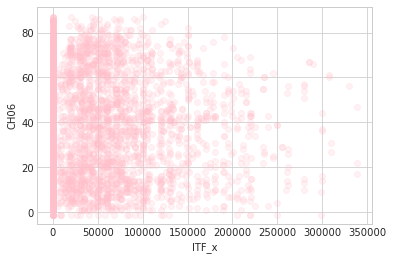

In [68]:
with plt.style.context('seaborn-whitegrid'):
    sns.regplot(x = 'ITF_x', y="CH06", data=eph_final_completa, fit_reg = False, scatter_kws={"alpha": 0.2}, color='pink')

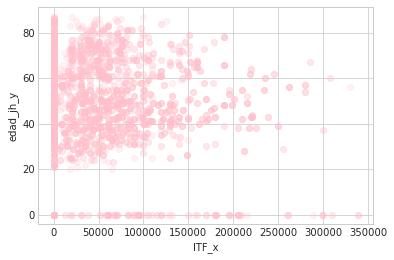

In [69]:
with plt.style.context('seaborn-whitegrid'):
    sns.regplot(x = 'ITF_x', y="edad_jh_y", data=eph_final_completa, fit_reg = False, scatter_kws={"alpha": 0.2}, color='pink')

In [70]:
# Seteamos la fuente de los gráficos 
plt.rcParams["font.family"] = "Times New Roman"

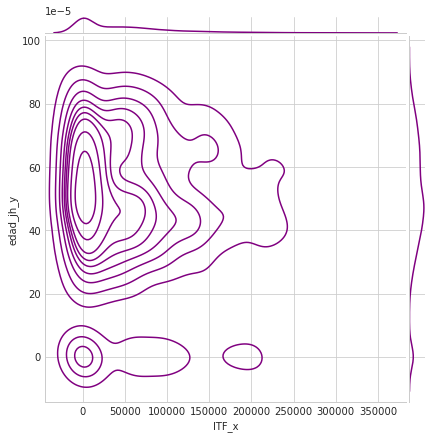

In [71]:
with plt.style.context('seaborn-whitegrid'):
    sns.jointplot(x = 'ITF_x', y="edad_jh_y", data=eph_final_completa, kind = 'kde', color='purple',ratio=20)

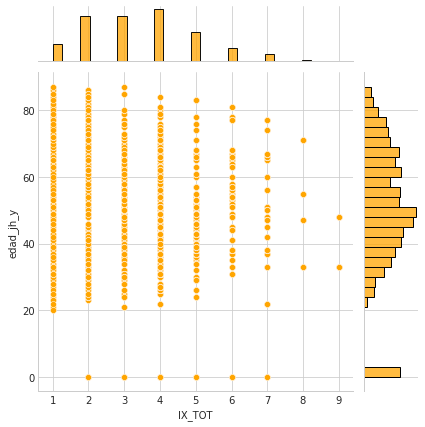

In [72]:
with plt.style.context('seaborn-whitegrid'):
    sns.jointplot(data=eph_final_completa, x = 'IX_TOT', y="edad_jh_y", color='orange')

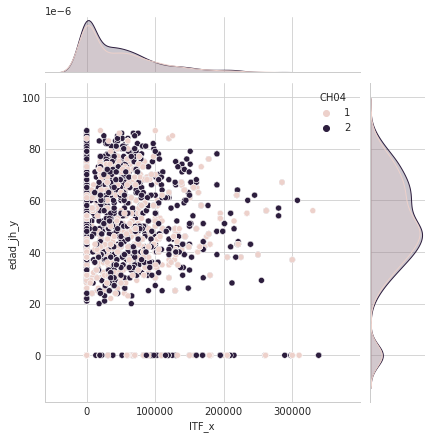

In [482]:
with plt.style.context('seaborn-whitegrid'):
    sns.jointplot(x = 'ITF_x', y="edad_jh_y", data=eph_final_completa, hue="CH04")

No se distingue una correlación positiva ni nevativa entre las variables ITF y la edad del jefe de hogar o jefa de hogar. También distinguimos para el caso de hombres y mujeres. 

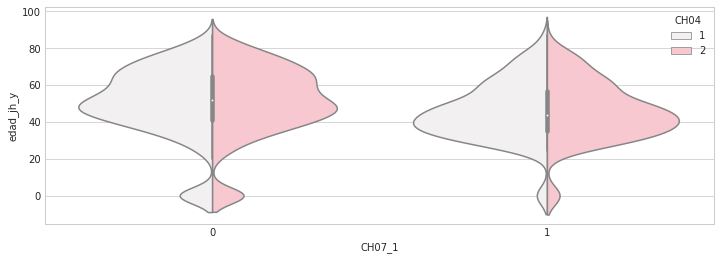

In [481]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize = (12,4))
    ax = sns.violinplot(x = 'CH07_1', y="edad_jh_y", data=eph_final_completa, hue="CH04", split=True, ax=ax, color='pink')

En el grafico anterior se observan las densidades de las variables correspondiente a la edad del jefe de hogar y la variable CH07 cuando toma valor igual a 1. Realizamos esto para hombres y para mujeres por separado. El número 2 corresponde a las mujeres y el 1 a los hombres. 

#### 6) 

In [75]:
equivalencia=pd.read_excel('tabla_adulto_equiv.xlsx')

In [76]:
# Guardamos los valores de las celdas en las listas 
equivalencia_filas=equivalencia.to_numpy().transpose().tolist()

In [77]:
# La idea es crear dos bases de datos distintas para luego hacer el merge con la EPH. 
# Estas dos bases de van a diferenciar en una variable "sexo" que tomará, para todas las observaciones, 
# un valor de 1 o 2. 

# En primer lugar, procederemos a armar la primera fila de los dos data frame
# Esta fila tendrá los valores referidos a la edad, es por esto que es una fila en común 
# entre ambas bases de datos. 

# Nos quedamos con el primer elemento de "equivalencia_filas" (edad):

fila0=equivalencia_filas[0]

# Nos quedamos solo con los valores que no son missings:

edad = [x for x in fila0 if pd.isnull(x) == False]

# Armamos la base de datos para las mujeres

# Nos quedamos solo con los elementos de la fila que nos van a servir (hay algunos 
# datos de edad que no son missing pero no son referidos a la edad sino que son notas)

edad=edad[1:24]

print(edad)

# Nos quedamos con la fila referida a la equivalencia:

fila1=equivalencia_filas[1]

mujeres_eq = [x for x in fila1 if pd.isnull(x) == False]

# Nos quedamos solo con los elementos de la fila que nos van a servir 

mujeres_eq=mujeres_eq[1:24]

print(mujeres_eq)

# Creamos una fila que tome valor igual a 2, esto será para luego poder hacer el merge 
# con la base de datos de la EPH

sexo=[2] * 24

print(sexo)

# Juntamos las filas y las transformamos en un data frame. 

mujeres = list(zip(edad, mujeres_eq, sexo))

# Cambiamos los nombres de las variables para que podamos hacer el merge con la EPH sin ninguna complicación

df_mujeres = pd.DataFrame(mujeres,columns=['edad','equivalencia','CH04'])

# Observamos el resultado

df_mujeres.head(5)

['Menor de 1 año', '1año', '2 años', '3 años', '4 años', '5 años', '6 años', '7 años', '8 años', '9 años', '10 años', '11 años', '12 años', '13 años', '14 años', '15 años', '16 años', '17 años', '18 a 29 años', '30 a 45 años', '46 a 60 años', '61 a 75 años', 'más de 75 años']
[0.35, 0.37, 0.46, 0.51, 0.55, 0.6, 0.64, 0.66, 0.68, 0.69, 0.7, 0.72, 0.74, 0.76, 0.76, 0.77, 0.77, 0.77, 0.76, 0.77, 0.76, 0.67, 0.63]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


,edad,equivalencia,CH04
0,Menor de 1 año,0.35,2
1,1año,0.37,2
2,2 años,0.46,2
3,3 años,0.51,2
4,4 años,0.55,2


In [78]:
# Armamos la base de datos para los hombres 

# Nos quedamos solo con los elementos de la fila que nos van a servir 

fila1_hombres=equivalencia_filas[2]

# Eliminamos los missing values

# esto sería: hombres_eq = [x for x in fila1_hombres (cambia esto) if pd.isnull(x) == False]

hombres_eq = [x for x in fila1_hombres if pd.isnull(x) == False]

# Nos quedamos solo con los elementos de la fila que nos van a servir 

hombres_eq = hombres_eq[1:24]

print(hombres_eq)

# Creamos una fila que tome valor igual a 1, esto será para luego poder hacer el merge 
# con la base de datos de la EPH

sexo=[1] * 24

print(sexo)

# Juntamos las filas y las transformamos en un data frame. 

hombres = list(zip(edad, hombres_eq, sexo))

# Cambiamos los nombres de las variables para que podamos hacer el merge con la EPH sin ninguna complicación

df_hombres = pd.DataFrame(hombres,columns=['edad','equivalencia','CH04'])

# Observamos el resultado

df_hombres.head(5)


[0.35, 0.37, 0.46, 0.51, 0.55, 0.6, 0.64, 0.66, 0.68, 0.69, 0.79, 0.82, 0.85, 0.9, 0.96, 1, 1.03, 1.04, 1.02, 1, 1, 0.83, 0.74]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


,edad,equivalencia,CH04
0,Menor de 1 año,0.35,1
1,1año,0.37,1
2,2 años,0.46,1
3,3 años,0.51,1
4,4 años,0.55,1


In [79]:
# Creamos una función que nos 
def combinacion_edad(x):
   
    #Esta función nos devuelve la categoría en la que entra cada individuo
    #según la edad que tenga, con categoría nos ayudará a hacer el match 
    #de la base de datos de la EPH con la tabla de equivalencias
    #Input: 
    #  edad (int): la edad a la que se desea transformar en esa misma edad solo que "con palabras"
    # Output:
    #  str: edad en palabras

    if x < 1:
        return 'Menor de 1 año'
    elif x == 1:
        return '1 año'
    elif x ==2: 
        return '2 años'
    elif x ==3: 
        return '3 años'
    elif x ==4: 
        return '4 años'
    elif x ==5: 
        return '5 años'
    elif x ==6: 
        return '6 años'
    elif x ==7: 
        return '7 años'
    elif x ==8: 
        return '8 años'
    elif x ==9: 
        return '9 años'
    elif x ==10: 
        return '10 años'
    elif x ==11: 
        return '11 años'
    elif x ==12: 
        return '12 años'
    elif x ==13: 
        return '13 años'
    elif x ==14: 
        return '14 años'
    elif x ==15: 
        return '15 años'
    elif x ==16: 
        return '16 años'
    elif x ==17: 
        return '17 años'      
    elif x >= 18 and x <= 29:
        return '18 a 29 años'
    elif x >= 30 and x <= 45:
        return '30 a 45 años'  
    elif x >= 46 and x <= 60:
        return '46 a 60 años'    
    elif x >= 61 and x <= 75:
        return '61 a 75 años'
    else:
        return 'mas de 75 años'


In [80]:
# Agregamos una nueva columna con la edad, en donde aplicamos la función 
eph_final_completa['edad']=[combinacion_edad(x) for x in eph_final_completa['CH06']]

eph_final_completa.head()

,index,TRIMESTRE_x,NRO_HOGAR,CODUSU,COMPONENTE,H15,REGION_x,AGLOMERADO_x,PONDERA_x,PONDIH_x,CH06,PP03D,PP3E_TOT,PP3F_TOT,PP04B2,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,TOT_P12,P47T,V18_M,V19_AM,V21_M,ITF_x,IX_TOT,IX_MEN10,IX_MAYEQ10,CH03_1,CH03_2,CH03_3,CH03_4,CH03_5,CH03_6,CH03_7,CH03_8,CH03_9,CH03_10,CH04_1,CH04_2,CH07_1,CH07_2,CH07_3,CH07_4,CH07_5,CH08_1,CH08_2,CH08_3,CH08_4,CH08_9,CH08_12,CH09_1,CH09_2,CH09_3,CH10_0,CH10_1,CH10_2,CH10_3,CH11_0,CH11_1,CH11_2,CH12_0,CH12_1,CH12_2,CH12_3,CH12_4,CH12_5,CH12_6,CH12_7,CH12_8,CH12_9,CH12_99,CH13_0,CH13_1,CH13_2,CH14_0.0,CH14_1.0,CH14_2.0,CH14_3.0,CH14_4.0,CH14_5.0,CH14_6.0,CH14_7.0,CH14_8.0,CH14_9.0,CH14_98.0,CH14_99.0,CH15_1,CH15_2,CH15_3,CH15_4,CH15_5,CH16_1,CH16_2,CH16_3,CH16_4,CH16_5,CH16_6,NIVEL_ED_1,NIVEL_ED_2,NIVEL_ED_3,NIVEL_ED_4,NIVEL_ED_5,NIVEL_ED_6,NIVEL_ED_7,ESTADO_0,ESTADO_1,ESTADO_2,ESTADO_3,ESTADO_4,CAT_OCUP_0,CAT_OCUP_1,CAT_OCUP_2,CAT_OCUP_3,CAT_OCUP_4,CAT_OCUP_9,CAT_INAC_0,CAT_INAC_1,CAT_INAC_2,CAT_INAC_3,CAT_INAC_4,CAT_INAC_5,CAT_INAC_6,CAT_INAC_7,PP02C1_0,PP02C1_1,PP02C1_2,PP02C2_0,PP02C2_1,PP02C2_2,PP02C3_0,PP02C3_1,PP02C3_2,PP02C4_0,PP02C4_1,PP02C4_2,PP02C5_0,PP02C5_1,PP02C5_2,PP02C6_0,PP02C6_1,PP02C6_2,PP02C7_0,PP02C7_1,PP02C7_2,PP02C8_0,PP02C8_1,PP02C8_2,PP02E_0,PP02E_1,PP02E_2,PP02E_3,PP02E_4,PP02E_5,PP02H_0,PP02H_1,PP02H_2,PP02I_0,PP02I_1,PP02I_2,PP03C_0.0,PP03C_1.0,PP03C_2.0,PP03C_9.0,PP03G_1.0,PP03G_2.0,PP03G_9.0,PP03H_0.0,PP03H_1.0,PP03H_2.0,PP03H_3.0,PP03H_9.0,PP03I_1.0,PP03I_2.0,PP03I_9.0,PP03J_1.0,PP03J_2.0,PP03J_9.0,INTENSI_1.0,INTENSI_2.0,INTENSI_3.0,INTENSI_4.0,INTENSI_9.0,PP04A_1.0,PP04A_2.0,PP04A_3.0,PP04A_9.0,PP04B1_1.0,PP04B1_2.0,PP04B1_9.0,PP04B3_MES_0.0,PP04B3_MES_1.0,PP04B3_MES_2.0,PP04B3_MES_4.0,PP04B3_MES_5.0,PP04B3_MES_6.0,PP04B3_MES_7.0,PP04B3_MES_8.0,PP04B3_MES_9.0,PP04B3_ANO_0.0,PP04B3_ANO_1.0,PP04B3_ANO_2.0,PP04B3_ANO_3.0,PP04B3_ANO_4.0,PP04B3_ANO_5.0,PP04B3_ANO_6.0,PP04B3_ANO_7.0,PP04B3_ANO_8.0,PP04B3_ANO_9.0,PP04B3_ANO_10.0,PP04B3_ANO_12.0,PP04B3_ANO_15.0,PP04B3_ANO_17.0,PP04B3_ANO_20.0,PP04B3_DIA_0.0,PP04B3_DIA_1.0,PP04B3_DIA_9.0,PP04B3_DIA_10.0,PP04B3_DIA_15.0,PP04C_0.0,PP04C_1.0,PP04C_2.0,PP04C_3.0,PP04C_4.0,PP04C_5.0,PP04C_6.0,PP04C_7.0,PP04C_8.0,PP04C_9.0,PP04C_10.0,PP04C_11.0,PP04C_12.0,PP04C_99.0,PP04C99_0.0,PP04C99_1.0,PP04C99_2.0,PP04C99_3.0,PP04C99_9.0,PP04G_0.0,PP04G_1.0,PP04G_2.0,PP04G_3.0,PP04G_4.0,PP04G_5.0,PP04G_6.0,PP04G_7.0,PP04G_8.0,PP04G_9.0,PP04G_10.0,PP05B2_MES_0.0,PP05B2_MES_3.0,PP05B2_MES_9.0,PP05B2_ANO_0.0,PP05B2_ANO_1.0,PP05B2_ANO_5.0,PP05B2_ANO_9.0,PP05B2_DIA_0.0,PP05B2_DIA_9.0,PP05C_1_0.0,PP05C_1_1.0,PP05C_1_2.0,PP05C_1_3.0,PP05C_1_9.0,PP05C_2_0.0,PP05C_2_1.0,PP05C_2_2.0,PP05C_2_3.0,PP05C_2_9.0,PP05C_3_0.0,PP05C_3_1.0,PP05C_3_2.0,PP05C_3_3.0,PP05C_3_9.0,PP05E_0.0,PP05E_1.0,PP05E_2.0,PP05E_9.0,PP05F_0.0,PP05F_6.0,PP05F_7.0,PP05F_9.0,PP05H_0.0,PP05H_1.0,PP05H_2.0,PP05H_3.0,PP05H_4.0,PP05H_5.0,PP05H_6.0,PP05H_9.0,PP06A_0.0,PP06A_1.0,PP06A_2.0,PP06A_9.0,PP06E_0.0,PP06E_1.0,PP06E_2.0,PP06E_3.0,PP06E_9.0,PP06H_0.0,PP06H_1.0,PP06H_2.0,PP06H_9.0,PP07A_0.0,PP07A_1.0,PP07A_2.0,PP07A_3.0,PP07A_4.0,PP07A_5.0,PP07A_6.0,PP07A_9.0,PP07C_0.0,PP07C_1.0,PP07C_2.0,PP07C_9.0,PP07D_0.0,PP07D_1.0,PP07D_2.0,PP07D_3.0,PP07D_4.0,PP07D_5.0,PP07D_9.0,PP07E_0.0,PP07E_1.0,PP07E_2.0,PP07E_3.0,PP07E_4.0,PP07E_9.0,PP07F1_0.0,PP07F1_1.0,PP07F1_2.0,PP07F1_9.0,PP07F2_0.0,PP07F2_1.0,PP07F2_2.0,PP07F2_9.0,PP07F3_0.0,PP07F3_1.0,PP07F3_2.0,PP07F3_9.0,PP07F4_0.0,PP07F4_1.0,PP07F4_2.0,PP07F4_9.0,PP07F5_0.0,PP07F5_5.0,PP07F5_9.0,PP07G1_0.0,PP07G1_1.0,PP07G1_2.0,PP07G1_9.0,PP07G2_0.0,PP07G2_1.0,PP07G2_2.0,PP07G2_9.0,PP07G3_0.0,PP07G3_1.0,PP07G3_2.0,PP07G3_9.0,PP07G4_0.0,PP07G4_1.0,PP07G4_2.0,PP07G4_9.0,PP07G_59_0.0,PP07G_59_5.0,PP07G_59_9.0,PP07H_0.0,PP07H_1.0,PP07H_2.0,PP07H_9.0,PP07I_0.0,PP07I_1.0,PP07I_2.0,PP07I_9.0,PP07J_0.0,PP07J_1.0,PP07J_2.0,PP07J_3.0,PP07J_9.0,PP07K_0.0,PP07K_1.0,PP07K_2.0,PP07K_3.0,PP07K_4.0,PP07K_5.0,PP07K_9.0,PP09A_1.0,PP09A_2.0,PP09A_3.0,PP09A_4.0,PP09A_9.0,PP09B_0.0,PP09B_9.0,PP09C_0.0,PP09C_9.0,IV1_1,IV1_2,IV1_3,IV1_

In [81]:
# Hacemos el merge de la EPH con la base de datos de equivalencia para hombres

result = pd.merge(eph_final_completa, df_hombres, how="left", on=["edad","CH04"])


In [82]:
# Hacemos el merge de la EPH con la base de datos de equivalencia para mujeres

result_eph = pd.merge(result, df_mujeres, how="left", on=["CH04", "edad"])

In [83]:
# Debido a que queremos tener los datos de equivalencia en una sola columna juntamos los datos de "equivalencia_x" y "equivalencia_y"
# en una sola columna. Notar que si hay valores missing en ambas columnas esto se mantiene en la nueva columna llamada "Equivalencia"

result_eph["Equivalencia"]=result_eph["equivalencia_x"].combine_first(result_eph["equivalencia_y"])

In [84]:
# Observamos los resultados 

result_eph.head()

,index,TRIMESTRE_x,NRO_HOGAR,CODUSU,COMPONENTE,H15,REGION_x,AGLOMERADO_x,PONDERA_x,PONDIH_x,CH06,PP03D,PP3E_TOT,PP3F_TOT,PP04B2,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,TOT_P12,P47T,V18_M,V19_AM,V21_M,ITF_x,IX_TOT,IX_MEN10,IX_MAYEQ10,CH03_1,CH03_2,CH03_3,CH03_4,CH03_5,CH03_6,CH03_7,CH03_8,CH03_9,CH03_10,CH04_1,CH04_2,CH07_1,CH07_2,CH07_3,CH07_4,CH07_5,CH08_1,CH08_2,CH08_3,CH08_4,CH08_9,CH08_12,CH09_1,CH09_2,CH09_3,CH10_0,CH10_1,CH10_2,CH10_3,CH11_0,CH11_1,CH11_2,CH12_0,CH12_1,CH12_2,CH12_3,CH12_4,CH12_5,CH12_6,CH12_7,CH12_8,CH12_9,CH12_99,CH13_0,CH13_1,CH13_2,CH14_0.0,CH14_1.0,CH14_2.0,CH14_3.0,CH14_4.0,CH14_5.0,CH14_6.0,CH14_7.0,CH14_8.0,CH14_9.0,CH14_98.0,CH14_99.0,CH15_1,CH15_2,CH15_3,CH15_4,CH15_5,CH16_1,CH16_2,CH16_3,CH16_4,CH16_5,CH16_6,NIVEL_ED_1,NIVEL_ED_2,NIVEL_ED_3,NIVEL_ED_4,NIVEL_ED_5,NIVEL_ED_6,NIVEL_ED_7,ESTADO_0,ESTADO_1,ESTADO_2,ESTADO_3,ESTADO_4,CAT_OCUP_0,CAT_OCUP_1,CAT_OCUP_2,CAT_OCUP_3,CAT_OCUP_4,CAT_OCUP_9,CAT_INAC_0,CAT_INAC_1,CAT_INAC_2,CAT_INAC_3,CAT_INAC_4,CAT_INAC_5,CAT_INAC_6,CAT_INAC_7,PP02C1_0,PP02C1_1,PP02C1_2,PP02C2_0,PP02C2_1,PP02C2_2,PP02C3_0,PP02C3_1,PP02C3_2,PP02C4_0,PP02C4_1,PP02C4_2,PP02C5_0,PP02C5_1,PP02C5_2,PP02C6_0,PP02C6_1,PP02C6_2,PP02C7_0,PP02C7_1,PP02C7_2,PP02C8_0,PP02C8_1,PP02C8_2,PP02E_0,PP02E_1,PP02E_2,PP02E_3,PP02E_4,PP02E_5,PP02H_0,PP02H_1,PP02H_2,PP02I_0,PP02I_1,PP02I_2,PP03C_0.0,PP03C_1.0,PP03C_2.0,PP03C_9.0,PP03G_1.0,PP03G_2.0,PP03G_9.0,PP03H_0.0,PP03H_1.0,PP03H_2.0,PP03H_3.0,PP03H_9.0,PP03I_1.0,PP03I_2.0,PP03I_9.0,PP03J_1.0,PP03J_2.0,PP03J_9.0,INTENSI_1.0,INTENSI_2.0,INTENSI_3.0,INTENSI_4.0,INTENSI_9.0,PP04A_1.0,PP04A_2.0,PP04A_3.0,PP04A_9.0,PP04B1_1.0,PP04B1_2.0,PP04B1_9.0,PP04B3_MES_0.0,PP04B3_MES_1.0,PP04B3_MES_2.0,PP04B3_MES_4.0,PP04B3_MES_5.0,PP04B3_MES_6.0,PP04B3_MES_7.0,PP04B3_MES_8.0,PP04B3_MES_9.0,PP04B3_ANO_0.0,PP04B3_ANO_1.0,PP04B3_ANO_2.0,PP04B3_ANO_3.0,PP04B3_ANO_4.0,PP04B3_ANO_5.0,PP04B3_ANO_6.0,PP04B3_ANO_7.0,PP04B3_ANO_8.0,PP04B3_ANO_9.0,PP04B3_ANO_10.0,PP04B3_ANO_12.0,PP04B3_ANO_15.0,PP04B3_ANO_17.0,PP04B3_ANO_20.0,PP04B3_DIA_0.0,PP04B3_DIA_1.0,PP04B3_DIA_9.0,PP04B3_DIA_10.0,PP04B3_DIA_15.0,PP04C_0.0,PP04C_1.0,PP04C_2.0,PP04C_3.0,PP04C_4.0,PP04C_5.0,PP04C_6.0,PP04C_7.0,PP04C_8.0,PP04C_9.0,PP04C_10.0,PP04C_11.0,PP04C_12.0,PP04C_99.0,PP04C99_0.0,PP04C99_1.0,PP04C99_2.0,PP04C99_3.0,PP04C99_9.0,PP04G_0.0,PP04G_1.0,PP04G_2.0,PP04G_3.0,PP04G_4.0,PP04G_5.0,PP04G_6.0,PP04G_7.0,PP04G_8.0,PP04G_9.0,PP04G_10.0,PP05B2_MES_0.0,PP05B2_MES_3.0,PP05B2_MES_9.0,PP05B2_ANO_0.0,PP05B2_ANO_1.0,PP05B2_ANO_5.0,PP05B2_ANO_9.0,PP05B2_DIA_0.0,PP05B2_DIA_9.0,PP05C_1_0.0,PP05C_1_1.0,PP05C_1_2.0,PP05C_1_3.0,PP05C_1_9.0,PP05C_2_0.0,PP05C_2_1.0,PP05C_2_2.0,PP05C_2_3.0,PP05C_2_9.0,PP05C_3_0.0,PP05C_3_1.0,PP05C_3_2.0,PP05C_3_3.0,PP05C_3_9.0,PP05E_0.0,PP05E_1.0,PP05E_2.0,PP05E_9.0,PP05F_0.0,PP05F_6.0,PP05F_7.0,PP05F_9.0,PP05H_0.0,PP05H_1.0,PP05H_2.0,PP05H_3.0,PP05H_4.0,PP05H_5.0,PP05H_6.0,PP05H_9.0,PP06A_0.0,PP06A_1.0,PP06A_2.0,PP06A_9.0,PP06E_0.0,PP06E_1.0,PP06E_2.0,PP06E_3.0,PP06E_9.0,PP06H_0.0,PP06H_1.0,PP06H_2.0,PP06H_9.0,PP07A_0.0,PP07A_1.0,PP07A_2.0,PP07A_3.0,PP07A_4.0,PP07A_5.0,PP07A_6.0,PP07A_9.0,PP07C_0.0,PP07C_1.0,PP07C_2.0,PP07C_9.0,PP07D_0.0,PP07D_1.0,PP07D_2.0,PP07D_3.0,PP07D_4.0,PP07D_5.0,PP07D_9.0,PP07E_0.0,PP07E_1.0,PP07E_2.0,PP07E_3.0,PP07E_4.0,PP07E_9.0,PP07F1_0.0,PP07F1_1.0,PP07F1_2.0,PP07F1_9.0,PP07F2_0.0,PP07F2_1.0,PP07F2_2.0,PP07F2_9.0,PP07F3_0.0,PP07F3_1.0,PP07F3_2.0,PP07F3_9.0,PP07F4_0.0,PP07F4_1.0,PP07F4_2.0,PP07F4_9.0,PP07F5_0.0,PP07F5_5.0,PP07F5_9.0,PP07G1_0.0,PP07G1_1.0,PP07G1_2.0,PP07G1_9.0,PP07G2_0.0,PP07G2_1.0,PP07G2_2.0,PP07G2_9.0,PP07G3_0.0,PP07G3_1.0,PP07G3_2.0,PP07G3_9.0,PP07G4_0.0,PP07G4_1.0,PP07G4_2.0,PP07G4_9.0,PP07G_59_0.0,PP07G_59_5.0,PP07G_59_9.0,PP07H_0.0,PP07H_1.0,PP07H_2.0,PP07H_9.0,PP07I_0.0,PP07I_1.0,PP07I_2.0,PP07I_9.0,PP07J_0.0,PP07J_1.0,PP07J_2.0,PP07J_3.0,PP07J_9.0,PP07K_0.0,PP07K_1.0,PP07K_2.0,PP07K_3.0,PP07K_4.0,PP07K_5.0,PP07K_9.0,PP09A_1.0,PP09A_2.0,PP09A_3.0,PP09A_4.0,PP09A_9.0,PP09B_0.0,PP09B_9.0,PP09C_0.0,PP09C_9.0,IV1_1,IV1_2,IV1_3,IV1_

In [85]:
# El archivo de consideraciones metodológicas del INDEC sobre la EPH nos dice que para agrupar por edades necesitamos usar 
# CODUSO y NRO_HOGAR. 

# Armamos una nueva base de datos que contenga las variables CODUSU, NRO_HOGAR y Equivalencia y las agrupamos por CODUSO y NRO_HOGAR
eph_equiv = result_eph[['CODUSU', 'NRO_HOGAR', 'Equivalencia']].groupby(['CODUSU', 'NRO_HOGAR']).sum().reset_index()
# Le damos el nombre a las columnas del data frame anterior
eph_equiv.rename(columns = {'Equivalencia': 'ad_equiv_hogar'}, inplace = True) 

# Unimos las base anterior con la base completa (result_eph), de esta forma, cada individuo tiene el valor correspondiente 
# de eph equiv por familia
eph_final = pd.merge(result_eph, eph_equiv, how='left', on=['CODUSU', 'NRO_HOGAR'])

In [86]:
(eph_final['ITF_x']==0).sum() # 1442

# Agregar comentario 

1422

In [87]:
(eph_final['ITF_x']>0).sum() # 2285


2285

In [443]:
# Guardamos como bases distintas según si respondieron o no ITF

respondieron = eph_final.loc[eph_final['ITF_x']>0]

no_respondieron = eph_final.loc[eph_final['ITF_x']==0]

In [444]:
# Creamos la variable ingreso_necesario en la base de datos "respondieron", esta variable resulta de multiplicar 
# 18914 por cada valor de "ad_equiv_hogar"

respondieron['ingreso_necesario']=18914*respondieron['ad_equiv_hogar']

# Observamos los resultados

respondieron.head(4)


<ipython-input-444-1e5a917ebcea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['ingreso_necesario']=18914*respondieron['ad_equiv_hogar']


,index,TRIMESTRE_x,NRO_HOGAR,CODUSU,COMPONENTE,H15,REGION_x,AGLOMERADO_x,PONDERA_x,PONDIH_x,CH06,PP03D,PP3E_TOT,PP3F_TOT,PP04B2,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,TOT_P12,P47T,V18_M,V19_AM,V21_M,ITF_x,IX_TOT,IX_MEN10,IX_MAYEQ10,CH03_1,CH03_2,CH03_3,CH03_4,CH03_5,CH03_6,CH03_7,CH03_8,CH03_9,CH03_10,CH04_1,CH04_2,CH07_1,CH07_2,CH07_3,CH07_4,CH07_5,CH08_1,CH08_2,CH08_3,CH08_4,CH08_9,CH08_12,CH09_1,CH09_2,CH09_3,CH10_0,CH10_1,CH10_2,CH10_3,CH11_0,CH11_1,CH11_2,CH12_0,CH12_1,CH12_2,CH12_3,CH12_4,CH12_5,CH12_6,CH12_7,CH12_8,CH12_9,CH12_99,CH13_0,CH13_1,CH13_2,CH14_0.0,CH14_1.0,CH14_2.0,CH14_3.0,CH14_4.0,CH14_5.0,CH14_6.0,CH14_7.0,CH14_8.0,CH14_9.0,CH14_98.0,CH14_99.0,CH15_1,CH15_2,CH15_3,CH15_4,CH15_5,CH16_1,CH16_2,CH16_3,CH16_4,CH16_5,CH16_6,NIVEL_ED_1,NIVEL_ED_2,NIVEL_ED_3,NIVEL_ED_4,NIVEL_ED_5,NIVEL_ED_6,NIVEL_ED_7,ESTADO_0,ESTADO_1,ESTADO_2,ESTADO_3,ESTADO_4,CAT_OCUP_0,CAT_OCUP_1,CAT_OCUP_2,CAT_OCUP_3,CAT_OCUP_4,CAT_OCUP_9,CAT_INAC_0,CAT_INAC_1,CAT_INAC_2,CAT_INAC_3,CAT_INAC_4,CAT_INAC_5,CAT_INAC_6,CAT_INAC_7,PP02C1_0,PP02C1_1,PP02C1_2,PP02C2_0,PP02C2_1,PP02C2_2,PP02C3_0,PP02C3_1,PP02C3_2,PP02C4_0,PP02C4_1,PP02C4_2,PP02C5_0,PP02C5_1,PP02C5_2,PP02C6_0,PP02C6_1,PP02C6_2,PP02C7_0,PP02C7_1,PP02C7_2,PP02C8_0,PP02C8_1,PP02C8_2,PP02E_0,PP02E_1,PP02E_2,PP02E_3,PP02E_4,PP02E_5,PP02H_0,PP02H_1,PP02H_2,PP02I_0,PP02I_1,PP02I_2,PP03C_0.0,PP03C_1.0,PP03C_2.0,PP03C_9.0,PP03G_1.0,PP03G_2.0,PP03G_9.0,PP03H_0.0,PP03H_1.0,PP03H_2.0,PP03H_3.0,PP03H_9.0,PP03I_1.0,PP03I_2.0,PP03I_9.0,PP03J_1.0,PP03J_2.0,PP03J_9.0,INTENSI_1.0,INTENSI_2.0,INTENSI_3.0,INTENSI_4.0,INTENSI_9.0,PP04A_1.0,PP04A_2.0,PP04A_3.0,PP04A_9.0,PP04B1_1.0,PP04B1_2.0,PP04B1_9.0,PP04B3_MES_0.0,PP04B3_MES_1.0,PP04B3_MES_2.0,PP04B3_MES_4.0,PP04B3_MES_5.0,PP04B3_MES_6.0,PP04B3_MES_7.0,PP04B3_MES_8.0,PP04B3_MES_9.0,PP04B3_ANO_0.0,PP04B3_ANO_1.0,PP04B3_ANO_2.0,PP04B3_ANO_3.0,PP04B3_ANO_4.0,PP04B3_ANO_5.0,PP04B3_ANO_6.0,PP04B3_ANO_7.0,PP04B3_ANO_8.0,PP04B3_ANO_9.0,PP04B3_ANO_10.0,PP04B3_ANO_12.0,PP04B3_ANO_15.0,PP04B3_ANO_17.0,PP04B3_ANO_20.0,PP04B3_DIA_0.0,PP04B3_DIA_1.0,PP04B3_DIA_9.0,PP04B3_DIA_10.0,PP04B3_DIA_15.0,PP04C_0.0,PP04C_1.0,PP04C_2.0,PP04C_3.0,PP04C_4.0,PP04C_5.0,PP04C_6.0,PP04C_7.0,PP04C_8.0,PP04C_9.0,PP04C_10.0,PP04C_11.0,PP04C_12.0,PP04C_99.0,PP04C99_0.0,PP04C99_1.0,PP04C99_2.0,PP04C99_3.0,PP04C99_9.0,PP04G_0.0,PP04G_1.0,PP04G_2.0,PP04G_3.0,PP04G_4.0,PP04G_5.0,PP04G_6.0,PP04G_7.0,PP04G_8.0,PP04G_9.0,PP04G_10.0,PP05B2_MES_0.0,PP05B2_MES_3.0,PP05B2_MES_9.0,PP05B2_ANO_0.0,PP05B2_ANO_1.0,PP05B2_ANO_5.0,PP05B2_ANO_9.0,PP05B2_DIA_0.0,PP05B2_DIA_9.0,PP05C_1_0.0,PP05C_1_1.0,PP05C_1_2.0,PP05C_1_3.0,PP05C_1_9.0,PP05C_2_0.0,PP05C_2_1.0,PP05C_2_2.0,PP05C_2_3.0,PP05C_2_9.0,PP05C_3_0.0,PP05C_3_1.0,PP05C_3_2.0,PP05C_3_3.0,PP05C_3_9.0,PP05E_0.0,PP05E_1.0,PP05E_2.0,PP05E_9.0,PP05F_0.0,PP05F_6.0,PP05F_7.0,PP05F_9.0,PP05H_0.0,PP05H_1.0,PP05H_2.0,PP05H_3.0,PP05H_4.0,PP05H_5.0,PP05H_6.0,PP05H_9.0,PP06A_0.0,PP06A_1.0,PP06A_2.0,PP06A_9.0,PP06E_0.0,PP06E_1.0,PP06E_2.0,PP06E_3.0,PP06E_9.0,PP06H_0.0,PP06H_1.0,PP06H_2.0,PP06H_9.0,PP07A_0.0,PP07A_1.0,PP07A_2.0,PP07A_3.0,PP07A_4.0,PP07A_5.0,PP07A_6.0,PP07A_9.0,PP07C_0.0,PP07C_1.0,PP07C_2.0,PP07C_9.0,PP07D_0.0,PP07D_1.0,PP07D_2.0,PP07D_3.0,PP07D_4.0,PP07D_5.0,PP07D_9.0,PP07E_0.0,PP07E_1.0,PP07E_2.0,PP07E_3.0,PP07E_4.0,PP07E_9.0,PP07F1_0.0,PP07F1_1.0,PP07F1_2.0,PP07F1_9.0,PP07F2_0.0,PP07F2_1.0,PP07F2_2.0,PP07F2_9.0,PP07F3_0.0,PP07F3_1.0,PP07F3_2.0,PP07F3_9.0,PP07F4_0.0,PP07F4_1.0,PP07F4_2.0,PP07F4_9.0,PP07F5_0.0,PP07F5_5.0,PP07F5_9.0,PP07G1_0.0,PP07G1_1.0,PP07G1_2.0,PP07G1_9.0,PP07G2_0.0,PP07G2_1.0,PP07G2_2.0,PP07G2_9.0,PP07G3_0.0,PP07G3_1.0,PP07G3_2.0,PP07G3_9.0,PP07G4_0.0,PP07G4_1.0,PP07G4_2.0,PP07G4_9.0,PP07G_59_0.0,PP07G_59_5.0,PP07G_59_9.0,PP07H_0.0,PP07H_1.0,PP07H_2.0,PP07H_9.0,PP07I_0.0,PP07I_1.0,PP07I_2.0,PP07I_9.0,PP07J_0.0,PP07J_1.0,PP07J_2.0,PP07J_3.0,PP07J_9.0,PP07K_0.0,PP07K_1.0,PP07K_2.0,PP07K_3.0,PP07K_4.0,PP07K_5.0,PP07K_9.0,PP09A_1.0,PP09A_2.0,PP09A_3.0,PP09A_4.0,PP09A_9.0,PP09B_0.0,PP09B_9.0,PP09C_0.0,PP09C_9.0,IV1_1,IV1_2,IV1_3,IV1_

In [445]:
# Calculamos la media de la variable ingreso necesario 

respondieron['ingreso_necesario'].mean() # 48939.4990


48939.49904595211

In [446]:
# Calculamos la media de la variable ITF

respondieron['ITF_x'].mean() # 78806.4118

78806.41181619256

#### 7)

In [447]:
# Creamos la variable pobre: 

# En principio solo toma como valor cero

respondieron['pobres']=0

# Reemplazamos con 1 en la variable 'pobre' si el ingreso necesario es menor al ITF que se respondió en la encuesta

respondieron.loc[respondieron.ingreso_necesario > respondieron.ITF_x, 'pobres']=1

<ipython-input-447-b181a6f43421>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['pobres']=0
C:\Users\Abi\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [448]:
# Calculamos la cantidad de pobres: 

respondieron['pobres'].value_counts()


0    1549
1     736
Name: pobres, dtype: int64

#### 8) 

La tasa de hogares bajo la línea de pobreza reportada por el INDEC es de 31,2%, esta
es muy similar a la calculada en este trabajo: 35.66%. Entre ambas tasas hay una diferencia de 4.46 puntos porcentuales.

In [449]:
# Definimos una base que contenga el ponderador y la columna que indica si el individuo es pobre o no agrupando por familia, de esta forma, queda una 
# sola observacion por familia, es decir, un solo individuo por familia

base_por_individuo=respondieron.groupby(['CODUSU','NRO_HOGAR']).agg({"PONDIH_x" : "sum", "pobres" : "mean"})

In [450]:
base_por_individuo.head()

,,PONDIH_x,pobres
CODUSU,NRO_HOGAR,,
TQRMNOPPQHJMQLCDEIJAH00702455,1,8056,0
TQRMNOPPQHJNMQCDEIJAH00698190,1,21840,1
TQRMNOPPQHJONQCDEIJAH00693114,1,4572,0
TQRMNOPPQHKMOSCDEIJAH00656008,1,15114,0
TQRMNOPPQHLMPPCDEIJAH00701610,1,25165,0


In [451]:
base_por_individuo.groupby("pobres").PONDIH_x.sum()

pobres
0    8733381
1    5011881
Name: PONDIH_x, dtype: int64

In [452]:
# De esta forma, la la tasa de hogares bajo la línea de pobreza para el GBA es del 36.46%

tasa_pobreza=5011881/(8733381+5011881)

tasa_pobreza

0.36462607988119833

## Parte 2

#### 1) 

In [101]:

# Importo paquetes a utilizar
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import plot_roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import expit
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

In [102]:
# Definimos un diccionario con los modelos: 

modelos = {
    "Regresion logistica": LogisticRegression(max_iter = 100000),
    "Analisis de discriminante lineal": LinearDiscriminantAnalysis(n_components=1), 
    "3 Vecinos cercanos": KNeighborsClassifier(n_neighbors=3)    
}


In [103]:
def evalua_metodo(modelos, X_train, y_train, X_test, y_test): 
    '''
    Función que evalua el desempeño de diferentes modelos
    Input: diccionario con los modelos y el comando correspondiente, matriz con las covariables de entrenamiento, matriz con la variable
    dependinte de entrenamiento, matriz con las covariables de test y matriz con la variable dependiente de test. 
    Output: matriz que contiene el ecm, matriz de confusión, presición y AUC de cada modelo. 
    
    '''
    matriz_completa = pd.DataFrame(columns=['Modelo','Matriz de confusión','La presición del modelo es','AUC','ECM'])    
    for nombre, modelo in modelos.items():
        # Ajustamos el modelo 
        modelo.fit(X_train, y_train)
        
        # Realizamos predicciónes sobre la base test 
        y_pred = modelo.predict(X_test)
        
        # Matriz de confusión y accuracy score
        matriz_confusion = confusion_matrix(y_test, y_pred)
        
        #Calculamos el área bajo la curva ROC
        auc = roc_auc_score(y_test, y_pred)
        prec=accuracy_score(y_test, y_pred)
        
        # Calculamos el ECM
        ecm = mean_squared_error(y_test, y_pred)
        #A = np.array([['Modelo','Matriz de confusión','La presición del modelo es','AUC','ECM'],[modelo,'none','none','none',ecm]])
        A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
        B=pd.DataFrame(A, columns=['Modelo','Matriz de confusión','La presición del modelo es','AUC','ECM'])
        matriz_completa = matriz_completa.append(B,ignore_index=True)
    return matriz_completa

In [104]:
modelos = {
    "Regresion logistica": LogisticRegression(max_iter = 100000),
    "Analisis de discriminante lineal": LinearDiscriminantAnalysis(n_components=1), 
    "3 Vecinos cercanos": KNeighborsClassifier(n_neighbors=3)    
}

In [105]:
prueba=evalua_metodo(modelos, X_train, y_train, X_test, y_test)

<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when

In [106]:
prueba.head()

,Modelo,Matriz de confusión,La presición del modelo es,AUC,ECM
0,Regresion logistica,"[[416, 49], [81, 140]]",0.810496,0.764054,0.189504
1,Analisis de discriminante lineal,"[[417, 48], [77, 144]]",0.817784,0.774179,0.182216
2,3 Vecinos cercanos,"[[381, 84], [101, 120]]",0.730321,0.681171,0.269679


In [107]:
hola=prueba.iloc[0, 4]

In [108]:
hola

0.18950437317784258

#### 2) 

In [109]:
modelos = {
    "Regresion logistica": LogisticRegression(max_iter = 100000)
}

In [110]:
def cross_validation(modelos, k, X,y):
    '''
    Función que realiza cross validation
    Input: diccionario con los modelos y su correspondiente comando con la configuración del modelo, k-fold elegido, matriz de X e y.
    Output: la media del ecm del modelo evaluado, es decir, la media entre las distintas particiones
    ''' 
    ecms_prueba = pd.DataFrame(columns=['Modelo','Matriz de confusión','La presición del modelo es','AUC','ECM','particion','k'])
    kf = KFold(n_splits=k, shuffle=True, random_state=100)
    kf.get_n_splits(X)
    KFold(n_splits=k, random_state=None, shuffle=False)
    count=1
    for train_index, test_index in kf.split(X):   
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        ecm = evalua_metodo(modelos, X_train, y_train, X_test, y_test)
        ecm['particion']=count
        ecm['k']=k
        ecms_prueba = ecms_prueba.append(ecm, ignore_index=True)
        count=count+1
    ecm_mean=ecms_prueba['ECM'].mean()
    return(ecm_mean)   


In [111]:
prueba_1=cross_validation(modelos, 5, X,y)

<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when

In [112]:
prueba_1

0.16498905908096279

#### 3)  

La función evalua_config optimiza los parámetros de los modelos: 
- k vecinos cercanos 
- regresión logística 


In [344]:
def evalua_config(modelo, lista_grados,k,X,y):
    '''
    Input: lista de modelos, matriz con las covariables y la variable, k-fold elegido y lista de parámetros a evaluar. 
    Output: parametro que minimiza el ecm. 
    
    '''
    for mod in modelo: 
        matriz_completa = pd.DataFrame(columns=["Modelo", "ECM","grado","configuracion"])
        matriz_c=pd.DataFrame()
        if mod=='Regresion logistica':
            for grade in lista_grados:
                h = [{"penalty":'l1', 'C': grade, "solver":'saga'}, {"penalty": 'l2', 'C': grade, "solver": 'saga'}, 
                     {"penalty": 'elasticnet', 'C': grade, "solver":'saga',"l1_ratio":0.5 }]
                for config in h:
                    modelos = {"Regresion logistica": LogisticRegression(**config,max_iter = 100000)}
                    matriz_c['ECM'] = cross_validation(modelos, k,X,y)
                    matriz_c['grado']=grade
                    matriz_c['Modelo']=modelo
                    print(grade)
                    #matriz_c['configuracion']=config['penalty']
                    #print(config)
                    matriz_completa = matriz_completa.append(matriz_c,ignore_index=True)
                    matriz_completa['ECM'] = pd.to_numeric(matriz_completa['ECM'])
                    print('hola')
            ecm_minimo = matriz_completa.nsmallest(1, 'ECM')
            #return ecm_minimo
            grado_elegido=ecm_minimo.iloc[0, 2]
            # print(grado_elegido)
            config_mejor = {"penalty":'l2', 'C': grado_elegido}
            return config_mejor
            # modelos = {"Regresion logistica": LogisticRegression(**config_mejor)}
            # ecm=evalua_metodo(modelos, X_train, y_train, X_test, y_test)
            #grado_elegido=ecm_minimo.iloc[0, 3]
            #modelo_elegido=evalua_config(modelo, X_train, ....)
            #print(grado_elegido)
        elif mod=='Vecinos cercanos': 
            for grade in lista_grados:
                h = [{"n_neighbors": grade}]
                for config in h:
                    modelos = {"Vecinos cercanos": KNeighborsClassifier(**config)}
                    matriz_c['ECM'] = cross_validation(modelos, k,X,y) ###### FALTABA UNA S, FIJARSE QUE EL TOME EL MODELO "CREADO"
                    matriz_c['grado']=grade
                    matriz_c['Modelo']=modelo
                    matriz_completa = matriz_completa.append(matriz_c,ignore_index=True)
                    matriz_completa['ECM'] = pd.to_numeric(matriz_completa['ECM'])
            ecm_minimo = matriz_completa.nsmallest(1, 'ECM')
            grado_elegido=ecm_minimo.iloc[0, 2] 
            
            return grado_elegido
        else: 
            print("No hay que optimizar parametros con este modelo")

No se llegó a cumplir del todo la consigna porque la función no sirve para cualquier hiperparámetro que quieran elegir por cross validation para cualquier modelo.
Por cuestiones de tiempo no pudimos mejorarlo, pero entendemos que para hacer eso deberiamos definir fuera de la función diccionarios con los parámetros para de esta forma poder unificar lo realizado. 

#### 4) 

In [314]:
import pandas as pd 
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics 
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

In [1]:
def evalua_multiples_metodos(modelos, lista_parametros, X, y, k):
    '''
    Función que evalua el desempeño de diferentes modelos con multiples metodos
    Input: lista de modelos (strings), matriz con las covariables y la variable
    dependinte, k-fold y lista de parámetros. 
    Output: matriz que contiene el ecm, matriz de confusión, presición y AUC de cada modelo, aparecen también aquellos modelos 
    para los cuales se elegio el parámetro por cross validation. 
    
    '''
    matriz_completa = pd.DataFrame(columns=['Modelo','Matriz de confusión','La presición del modelo es','AUC','ECM'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    for model in modelos:
        if model=='Regresion logistica':
            modelos_1 = {"Regresion logistica": LogisticRegression}
            parametro_elegido_rl=evalua_config(modelos_1,lista_parametros,k,X,y)
            print(parametro_elegido_rl) 
            reg_log={"Regresion logistica": LogisticRegression(**parametro_elegido_rl,max_iter = 100000)}
            resultados=evalua_metodo(reg_log, X_train, y_train, X_test, y_test)
            #return(resultados_rl)
        if model =='Vecinos cercanos':
            modelos_1={"Vecinos cercanos": KNeighborsClassifier}
            parametro_elegido_vc=evalua_config(modelos_1,lista_parametros,k,X,y)
            vc={"Vecinos cercanos": KNeighborsClassifier(n_neighbors=parametro_elegido_vc)}
            resultados=evalua_metodo(vc, X_train, y_train, X_test, y_test)
            #return resultados_cv
        if model == 'Analisis discriminante':
            analisis_disc={"Analisis discriminante":LinearDiscriminantAnalysis(n_components=1)}
            resultados=evalua_metodo(analisis_disc, X_train, y_train, X_test, y_test) 
            #return ecm_ad
        if model == 'Arbol de desicion':
            arbol = {"Arbol de decision": DecisionTreeClassifier(max_depth = 4)}
            resultados=evalua_metodo(arbol, X_train, y_train, X_test, y_test) 
            #return ecm_arbol
        if model == 'Bagging':
            bag={"Bagging": BaggingClassifier(n_estimators=2, max_samples=3, random_state=0)}
            resultados = evalua_metodo(bag, X_train, y_train, X_test, y_test) 
            #return ecm_bag
        if model == 'Random forest':
            rf={"Random forest": RandomForestClassifier(n_estimators=5, max_samples=20, max_features=9, random_state=0)}
            resultados = evalua_metodo(rf, X_train, y_train, X_test, y_test) 
            #return ecm_rf
        if model == 'Boosting':
            ab={"Boosting": AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200)}
            resultados = evalua_metodo(ab, X_train, y_train, X_test, y_test) 
            #return ecm_rf
        if model == 'Support vector machines':
            svm= {"Support vector machines": make_pipeline(StandardScaler(), GaussianNB(priors=None))}
            resultados = evalua_metodo(svm, X_train, y_train, X_test, y_test) 
            #return ecm_svm
        else: 
            print('no funciona')
        matriz_completa = matriz_completa.append(resultados,ignore_index=True)
    return matriz_completa


### Parte 3 



#### 1) 

In [453]:


y = respondieron['pobres'] 
X = respondieron.loc[:,['REGION_x',
 'AGLOMERADO_x',
 'CH06',
 'PP03D',
 'PP3E_TOT',
 'PP3F_TOT',
 'PP04B2',
 'TOT_P12',
 'P47T',
 'V18_M',
 'V19_AM',
 'V21_M',
 'IX_TOT',
 'IX_MEN10',
 'IX_MAYEQ10',
 'CH03_1',
 'CH03_2',
 'CH03_3',
 'CH03_4',
 'CH03_5',
 'CH03_6',
 'CH03_7',
 'CH03_8',
 'CH03_9',
 'CH03_10',
 'CH04_1',
 'CH04_2',
 'CH07_1',
 'CH07_2',
 'CH07_3',
 'CH07_4',
 'CH07_5',
 'CH08_1',
 'CH08_2',
 'CH08_3',
 'CH08_4',
 'CH08_9',
 'CH08_12',
 'CH09_1',
 'CH09_2',
 'CH09_3',
 'CH10_0',
 'CH10_1',
 'CH10_2',
 'CH10_3',
 'CH11_0',
 'CH11_1',
 'CH11_2',
 'CH12_0',
 'CH12_1',
 'CH12_2',
 'CH12_3',
 'CH12_4',
 'CH12_5',
 'CH12_6',
 'CH12_7',
 'CH12_8',
 'CH12_9',
 'CH12_99',
 'CH13_0',
 'CH13_1',
 'CH13_2',
 'CH14_0.0',
 'CH14_1.0',
 'CH14_2.0',
 'CH14_3.0',
 'CH14_4.0',
 'CH14_5.0',
 'CH14_6.0',
 'CH14_7.0',
 'CH14_8.0',
 'CH14_9.0',
 'CH14_98.0',
 'CH14_99.0',
 'CH15_1',
 'CH15_2',
 'CH15_3',
 'CH15_4',
 'CH15_5',
 'CH16_1',
 'CH16_2',
 'CH16_3',
 'CH16_4',
 'CH16_5',
 'CH16_6',
 'NIVEL_ED_1',
 'NIVEL_ED_2',
 'NIVEL_ED_3',
 'NIVEL_ED_4',
 'NIVEL_ED_5',
 'NIVEL_ED_6',
 'NIVEL_ED_7',
 'ESTADO_0',
 'ESTADO_1',
 'ESTADO_2',
 'ESTADO_3',
 'ESTADO_4',
 'CAT_OCUP_0',
 'CAT_OCUP_1',
 'CAT_OCUP_2',
 'CAT_OCUP_3',
 'CAT_OCUP_4',
 'CAT_OCUP_9',
 'CAT_INAC_0',
 'CAT_INAC_1',
 'CAT_INAC_2',
 'CAT_INAC_3',
 'CAT_INAC_4',
 'CAT_INAC_5',
 'CAT_INAC_6',
 'CAT_INAC_7',
 'PP02C1_0',
 'PP02C1_1',
 'PP02C1_2',
 'PP02C2_0',
 'PP02C2_1',
 'PP02C2_2',
 'PP02C3_0',
 'PP02C3_1',
 'PP02C3_2',
 'PP02C4_0',
 'PP02C4_1',
 'PP02C4_2',
 'PP02C5_0',
 'PP02C5_1',
 'PP02C5_2',
 'PP02C6_0',
 'PP02C6_1',
 'PP02C6_2',
 'PP02C7_0',
 'PP02C7_1',
 'PP02C7_2',
 'PP02C8_0',
 'PP02C8_1',
 'PP02C8_2',
 'PP02E_0',
 'PP02E_1',
 'PP02E_2',
 'PP02E_3',
 'PP02E_4',
 'PP02E_5',
 'PP02H_0',
 'PP02H_1',
 'PP02H_2',
 'PP02I_0',
 'PP02I_1',
 'PP02I_2',
 'PP03C_0.0',
 'PP03C_1.0',
 'PP03C_2.0',
 'PP03C_9.0',
 'PP03G_1.0',
 'PP03G_2.0',
 'PP03G_9.0',
 'PP03H_0.0',
 'PP03H_1.0',
 'PP03H_2.0',
 'PP03H_3.0',
 'PP03H_9.0',
 'PP03I_1.0',
 'PP03I_2.0',
 'PP03I_9.0',
 'PP03J_1.0',
 'PP03J_2.0',
 'PP03J_9.0',
 'INTENSI_1.0',
 'INTENSI_2.0',
 'INTENSI_3.0',
 'INTENSI_4.0',
 'INTENSI_9.0',
 'PP04A_1.0',
 'PP04A_2.0',
 'PP04A_3.0',
 'PP04A_9.0',
 'PP04B1_1.0',
 'PP04B1_2.0',
 'PP04B1_9.0',
 'PP04B3_MES_0.0',
 'PP04B3_MES_1.0',
 'PP04B3_MES_2.0',
 'PP04B3_MES_4.0',
 'PP04B3_MES_5.0',
 'PP04B3_MES_6.0',
 'PP04B3_MES_7.0',
 'PP04B3_MES_8.0',
 'PP04B3_MES_9.0',
 'PP04B3_ANO_0.0',
 'PP04B3_ANO_1.0',
 'PP04B3_ANO_2.0',
 'PP04B3_ANO_3.0',
 'PP04B3_ANO_4.0',
 'PP04B3_ANO_5.0',
 'PP04B3_ANO_6.0',
 'PP04B3_ANO_7.0',
 'PP04B3_ANO_8.0',
 'PP04B3_ANO_9.0',
 'PP04B3_ANO_10.0',
 'PP04B3_ANO_12.0',
 'PP04B3_ANO_15.0',
 'PP04B3_ANO_17.0',
 'PP04B3_ANO_20.0',
 'PP04B3_DIA_0.0',
 'PP04B3_DIA_1.0',
 'PP04B3_DIA_9.0',
 'PP04B3_DIA_10.0',
 'PP04B3_DIA_15.0',
 'PP04C_0.0',
 'PP04C_1.0',
 'PP04C_2.0',
 'PP04C_3.0',
 'PP04C_4.0',
 'PP04C_5.0',
 'PP04C_6.0',
 'PP04C_7.0',
 'PP04C_8.0',
 'PP04C_9.0',
 'PP04C_10.0',
 'PP04C_11.0',
 'PP04C_12.0',
 'PP04C_99.0',
 'PP04C99_0.0',
 'PP04C99_1.0',
 'PP04C99_2.0',
 'PP04C99_3.0',
 'PP04C99_9.0',
 'PP04G_0.0',
 'PP04G_1.0',
 'PP04G_2.0',
 'PP04G_3.0',
 'PP04G_4.0',
 'PP04G_5.0',
 'PP04G_6.0',
 'PP04G_7.0',
 'PP04G_8.0',
 'PP04G_9.0',
 'PP04G_10.0',
 'PP05B2_MES_0.0',
 'PP05B2_MES_3.0',
 'PP05B2_MES_9.0',
 'PP05B2_ANO_0.0',
 'PP05B2_ANO_1.0',
 'PP05B2_ANO_5.0',
 'PP05B2_ANO_9.0',
 'PP05B2_DIA_0.0',
 'PP05B2_DIA_9.0',
 'PP05C_1_0.0',
 'PP05C_1_1.0',
 'PP05C_1_2.0',
 'PP05C_1_3.0',
 'PP05C_1_9.0',
 'PP05C_2_0.0',
 'PP05C_2_1.0',
 'PP05C_2_2.0',
 'PP05C_2_3.0',
 'PP05C_2_9.0',
 'PP05C_3_0.0',
 'PP05C_3_1.0',
 'PP05C_3_2.0',
 'PP05C_3_3.0',
 'PP05C_3_9.0',
 'PP05E_0.0',
 'PP05E_1.0',
 'PP05E_2.0',
 'PP05E_9.0',
 'PP05F_0.0',
 'PP05F_6.0',
 'PP05F_7.0',
 'PP05F_9.0',
 'PP05H_0.0',
 'PP05H_1.0',
 'PP05H_2.0',
 'PP05H_3.0',
 'PP05H_4.0',
 'PP05H_5.0',
 'PP05H_6.0',
 'PP05H_9.0',
 'PP06A_0.0',
 'PP06A_1.0',
 'PP06A_2.0',
 'PP06A_9.0',
 'PP06E_0.0',
 'PP06E_1.0',
 'PP06E_2.0',
 'PP06E_3.0',
 'PP06E_9.0',
 'PP06H_0.0',
 'PP06H_1.0',
 'PP06H_2.0',
 'PP06H_9.0',
 'PP07A_0.0',
 'PP07A_1.0',
 'PP07A_2.0',
 'PP07A_3.0',
 'PP07A_4.0',
 'PP07A_5.0',
 'PP07A_6.0',
 'PP07A_9.0',
 'PP07C_0.0',
 'PP07C_1.0',
 'PP07C_2.0',
 'PP07C_9.0',
 'PP07D_0.0',
 'PP07D_1.0',
 'PP07D_2.0',
 'PP07D_3.0',
 'PP07D_4.0',
 'PP07D_5.0',
 'PP07D_9.0',
 'PP07E_0.0',
 'PP07E_1.0',
 'PP07E_2.0',
 'PP07E_3.0',
 'PP07E_4.0',
 'PP07E_9.0',
 'PP07F1_0.0',
 'PP07F1_1.0',
 'PP07F1_2.0',
 'PP07F1_9.0',
 'PP07F2_0.0',
 'PP07F2_1.0',
 'PP07F2_2.0',
 'PP07F2_9.0',
 'PP07F3_0.0',
 'PP07F3_1.0',
 'PP07F3_2.0',
 'PP07F3_9.0',
 'PP07F4_0.0',
 'PP07F4_1.0',
 'PP07F4_2.0',
 'PP07F4_9.0',
 'PP07F5_0.0',
 'PP07F5_5.0',
 'PP07F5_9.0',
 'PP07G1_0.0',
 'PP07G1_1.0',
 'PP07G1_2.0',
 'PP07G1_9.0',
 'PP07G2_0.0',
 'PP07G2_1.0',
 'PP07G2_2.0',
 'PP07G2_9.0',
 'PP07G3_0.0',
 'PP07G3_1.0',
 'PP07G3_2.0',
 'PP07G3_9.0',
 'PP07G4_0.0',
 'PP07G4_1.0',
 'PP07G4_2.0',
 'PP07G4_9.0',
 'PP07G_59_0.0',
 'PP07G_59_5.0',
 'PP07G_59_9.0',
 'PP07H_0.0',
 'PP07H_1.0',
 'PP07H_2.0',
 'PP07H_9.0',
 'PP07I_0.0',
 'PP07I_1.0',
 'PP07I_2.0',
 'PP07I_9.0',
 'PP07J_0.0',
 'PP07J_1.0',
 'PP07J_2.0',
 'PP07J_3.0',
 'PP07J_9.0',
 'PP07K_0.0',
 'PP07K_1.0',
 'PP07K_2.0',
 'PP07K_3.0',
 'PP07K_4.0',
 'PP07K_5.0',
 'PP07K_9.0',
 'PP09A_1.0',
 'PP09A_2.0',
 'PP09A_3.0',
 'PP09A_4.0',
 'PP09A_9.0',
 'PP09B_0.0',
 'PP09B_9.0',
 'PP09C_0.0',
 'PP09C_9.0',
 'IV1_1',
 'IV1_2',
 'IV1_3',
 'IV1_4',
 'IV2_1.0',
 'IV2_2.0',
 'IV2_3.0',
 'IV2_4.0',
 'IV2_5.0',
 'IV2_6.0',
 'IV2_7.0',
 'IV3_1',
 'IV3_2',
 'IV3_3',
 'IV3_4',
 'IV4_1',
 'IV4_2',
 'IV4_3',
 'IV4_4',
 'IV4_5',
 'IV4_9',
 'IV5_1',
 'IV5_2',
 'IV6_1',
 'IV6_2',
 'IV6_3',
 'IV7_1',
 'IV7_2',
 'IV7_3',
 'IV7_4',
 'IV8_1',
 'IV8_2',
 'IV9_0',
 'IV9_1',
 'IV9_2',
 'IV10_0',
 'IV10_1',
 'IV10_2',
 'IV11_0',
 'IV11_1',
 'IV11_2',
 'IV11_3',
 'IV12_1_1',
 'IV12_1_2',
 'IV12_2_1',
 'IV12_2_2',
 'IV12_3_1',
 'IV12_3_2',
 'II1_1.0',
 'II1_2.0',
 'II1_3.0',
 'II1_4.0',
 'II1_5.0',
 'II1_6.0',
 'II1_7.0',
 'II2_1.0',
 'II2_2.0',
 'II2_3.0',
 'II2_4.0',
 'II3_1',
 'II3_2',
 'II3_1_0',
 'II3_1_1',
 'II3_1_2',
 'II4_1_1',
 'II4_1_2',
 'II4_2_1',
 'II4_2_2',
 'II4_3_1',
 'II4_3_2',
 'II5_0',
 'II5_1',
 'II5_2',
 'II5_1_0',
 'II5_1_1',
 'II5_1_2',
 'II6_0',
 'II6_1',
 'II6_2',
 'II6_1_0',
 'II6_1_1',
 'II6_1_2',
 'II7_1',
 'II7_2',
 'II7_3',
 'II7_4',
 'II7_5',
 'II7_6',
 'II7_7',
 'II7_8',
 'II7_9',
 'II8_1',
 'II8_2',
 'II8_4',
 'II9_1',
 'II9_2',
 'II9_3',
 'II9_4',
 'V1_1',
 'V1_2',
 'V1_9',
 'V2_1',
 'V2_2',
 'V2_9',
 'V21_1',
 'V21_2',
 'V22_2',
 'V3_1',
 'V3_2',
 'V3_9',
 'V4_1',
 'V4_2',
 'V4_9',
 'V5_1',
 'V5_2',
 'V5_9',
 'V6_1',
 'V6_2',
 'V6_9',
 'V7_1',
 'V7_2',
 'V7_9',
 'V8_1',
 'V8_2',
 'V8_9',
 'V9_1',
 'V9_2',
 'V9_9',
 'V10_1',
 'V10_2',
 'V10_9',
 'V11_1',
 'V11_2',
 'V11_9',
 'V12_1',
 'V12_2',
 'V12_9',
 'V13_1',
 'V13_2',
 'V13_9',
 'V14_1',
 'V14_2',
 'V14_9',
 'V15_1',
 'V15_2',
 'V15_9',
 'V16_1',
 'V16_2',
 'V16_9',
 'V17_1',
 'V17_2',
 'V17_9',
 'V18_1',
 'V18_2',
 'V18_9',
 'V19_A_2',
 'V19_A_9',
 'V19_B_1',
 'V19_B_2',
 'V19_B_9',
 'VII1_1_1',
 'VII1_1_2',
 'VII1_1_3',
 'VII1_1_4',
 'VII1_1_5',
 'VII1_1_7',
 'VII1_1_96',
 'VII1_1_97',
 'VII1_1_98',
 'VII1_1_99',
 'VII1_2_0',
 'VII1_2_1',
 'VII1_2_2',
 'VII1_2_3',
 'VII1_2_4',
 'VII1_2_5',
 'VII1_2_97',
 'VII2_1_1',
 'VII2_1_2',
 'VII2_1_3',
 'VII2_1_4',
 'VII2_1_5',
 'VII2_1_6',
 'VII2_1_8',
 'VII2_1_96',
 'VII2_1_97',
 'VII2_1_98',
 'VII2_1_99',
 'VII2_2_0',
 'VII2_2_1',
 'VII2_2_2',
 'VII2_2_3',
 'VII2_2_4',
 'VII2_2_5',
 'VII2_2_6',
 'VII2_2_7',
 'VII2_3_0',
 'VII2_3_1',
 'VII2_3_2',
 'VII2_3_3',
 'VII2_3_4',
 'VII2_3_5',
 'VII2_3_6',
 'VII2_4_0',
 'VII2_4_3',
 'VII2_4_5',
 'CH04',
 'edad_jh_y',
 'primaria_incom_jh_y',
 'secundario_incom_jh_y',
 'jefe_hogar_mujer_y',
 'jefe_hogar_hombre_y']]






X = sm.add_constant(X)

In [454]:
X=X.reset_index()

In [480]:
len(X.columns)

594

#### 2)

In [456]:
# Divido a la base respondieron en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [457]:
# Definimos la lista de modelos 
modelos=['Regresion logistica', 'Vecinos cercanos', 'Analisis discriminante', 'Arbol de desicion', 'Bagging', 'Random forest', 'Boosting', 'Support vector machines']

In [382]:
prueba=evalua_multiples_metodos(modelos,[2,3,7], X, y,2) 

<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])


2
hola


<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])


2
hola


<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])


2
hola


<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])


3
hola


<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])


3
hola


<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])


3
hola


<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])


7
hola


<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])


7
hola


<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])


7
hola
{'penalty': 'l2', 'C': 2}


<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])


no funciona


<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when

no funciona


<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when

no funciona
no funciona
no funciona


<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])


no funciona
no funciona


<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])
<ipython-input-103-9e66f5255d1e>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[nombre,matriz_confusion,prec,auc,ecm]])


In [386]:
prueba

,Modelo,Matriz de confusión,La presición del modelo es,AUC,ECM
0,Regresion logistica,"[[418, 47], [78, 143]]",0.817784,0.772992,0.182216
1,Vecinos cercanos,"[[387, 78], [111, 110]]",0.72449,0.664998,0.27551
2,Analisis discriminante,"[[417, 48], [77, 144]]",0.817784,0.774179,0.182216
3,Arbol de decision,"[[419, 46], [85, 136]]",0.809038,0.75823,0.190962
4,Bagging,"[[447, 18], [201, 20]]",0.680758,0.525894,0.319242
5,Random forest,"[[451, 14], [185, 36]]",0.709913,0.566394,0.290087
6,Boosting,"[[426, 39], [70, 151]]",0.841108,0.799693,0.158892
7,Support vector machines,"[[184, 281], [21, 200]]",0.559767,0.650338,0.440233


#### 3) 

Observamos que el modelo que obtiene un error cuadrático medio menor es Boosting. Para este modelo utilizamos un clasificador de arbol (DecisionTreeClassifier) con un max depth igual a 1 y una cantidad de n_estimators igual a 200. 

#### 4) 

Creemos que logramos mejorar las predicciones con respecto al TP3 debido a que corregimos errores de las funciones, aunque también 
esto puede deberse a las variables que creeamos, pero debido a que no utilizamos la misma metodología para el trabajo anterior no son comparables 
los resultados obtenidos. 

#### 5) 

In [460]:
no_respondieron_1 = no_respondieron.loc[:,['REGION_x',
 'AGLOMERADO_x',
 'CH06',
 'PP03D',
 'PP3E_TOT',
 'PP3F_TOT',
 'PP04B2',
 'TOT_P12',
 'P47T',
 'V18_M',
 'V19_AM',
 'V21_M',
 'IX_TOT',
 'IX_MEN10',
 'IX_MAYEQ10',
 'CH03_1',
 'CH03_2',
 'CH03_3',
 'CH03_4',
 'CH03_5',
 'CH03_6',
 'CH03_7',
 'CH03_8',
 'CH03_9',
 'CH03_10',
 'CH04_1',
 'CH04_2',
 'CH07_1',
 'CH07_2',
 'CH07_3',
 'CH07_4',
 'CH07_5',
 'CH08_1',
 'CH08_2',
 'CH08_3',
 'CH08_4',
 'CH08_9',
 'CH08_12',
 'CH09_1',
 'CH09_2',
 'CH09_3',
 'CH10_0',
 'CH10_1',
 'CH10_2',
 'CH10_3',
 'CH11_0',
 'CH11_1',
 'CH11_2',
 'CH12_0',
 'CH12_1',
 'CH12_2',
 'CH12_3',
 'CH12_4',
 'CH12_5',
 'CH12_6',
 'CH12_7',
 'CH12_8',
 'CH12_9',
 'CH12_99',
 'CH13_0',
 'CH13_1',
 'CH13_2',
 'CH14_0.0',
 'CH14_1.0',
 'CH14_2.0',
 'CH14_3.0',
 'CH14_4.0',
 'CH14_5.0',
 'CH14_6.0',
 'CH14_7.0',
 'CH14_8.0',
 'CH14_9.0',
 'CH14_98.0',
 'CH14_99.0',
 'CH15_1',
 'CH15_2',
 'CH15_3',
 'CH15_4',
 'CH15_5',
 'CH16_1',
 'CH16_2',
 'CH16_3',
 'CH16_4',
 'CH16_5',
 'CH16_6',
 'NIVEL_ED_1',
 'NIVEL_ED_2',
 'NIVEL_ED_3',
 'NIVEL_ED_4',
 'NIVEL_ED_5',
 'NIVEL_ED_6',
 'NIVEL_ED_7',
 'ESTADO_0',
 'ESTADO_1',
 'ESTADO_2',
 'ESTADO_3',
 'ESTADO_4',
 'CAT_OCUP_0',
 'CAT_OCUP_1',
 'CAT_OCUP_2',
 'CAT_OCUP_3',
 'CAT_OCUP_4',
 'CAT_OCUP_9',
 'CAT_INAC_0',
 'CAT_INAC_1',
 'CAT_INAC_2',
 'CAT_INAC_3',
 'CAT_INAC_4',
 'CAT_INAC_5',
 'CAT_INAC_6',
 'CAT_INAC_7',
 'PP02C1_0',
 'PP02C1_1',
 'PP02C1_2',
 'PP02C2_0',
 'PP02C2_1',
 'PP02C2_2',
 'PP02C3_0',
 'PP02C3_1',
 'PP02C3_2',
 'PP02C4_0',
 'PP02C4_1',
 'PP02C4_2',
 'PP02C5_0',
 'PP02C5_1',
 'PP02C5_2',
 'PP02C6_0',
 'PP02C6_1',
 'PP02C6_2',
 'PP02C7_0',
 'PP02C7_1',
 'PP02C7_2',
 'PP02C8_0',
 'PP02C8_1',
 'PP02C8_2',
 'PP02E_0',
 'PP02E_1',
 'PP02E_2',
 'PP02E_3',
 'PP02E_4',
 'PP02E_5',
 'PP02H_0',
 'PP02H_1',
 'PP02H_2',
 'PP02I_0',
 'PP02I_1',
 'PP02I_2',
 'PP03C_0.0',
 'PP03C_1.0',
 'PP03C_2.0',
 'PP03C_9.0',
 'PP03G_1.0',
 'PP03G_2.0',
 'PP03G_9.0',
 'PP03H_0.0',
 'PP03H_1.0',
 'PP03H_2.0',
 'PP03H_3.0',
 'PP03H_9.0',
 'PP03I_1.0',
 'PP03I_2.0',
 'PP03I_9.0',
 'PP03J_1.0',
 'PP03J_2.0',
 'PP03J_9.0',
 'INTENSI_1.0',
 'INTENSI_2.0',
 'INTENSI_3.0',
 'INTENSI_4.0',
 'INTENSI_9.0',
 'PP04A_1.0',
 'PP04A_2.0',
 'PP04A_3.0',
 'PP04A_9.0',
 'PP04B1_1.0',
 'PP04B1_2.0',
 'PP04B1_9.0',
 'PP04B3_MES_0.0',
 'PP04B3_MES_1.0',
 'PP04B3_MES_2.0',
 'PP04B3_MES_4.0',
 'PP04B3_MES_5.0',
 'PP04B3_MES_6.0',
 'PP04B3_MES_7.0',
 'PP04B3_MES_8.0',
 'PP04B3_MES_9.0',
 'PP04B3_ANO_0.0',
 'PP04B3_ANO_1.0',
 'PP04B3_ANO_2.0',
 'PP04B3_ANO_3.0',
 'PP04B3_ANO_4.0',
 'PP04B3_ANO_5.0',
 'PP04B3_ANO_6.0',
 'PP04B3_ANO_7.0',
 'PP04B3_ANO_8.0',
 'PP04B3_ANO_9.0',
 'PP04B3_ANO_10.0',
 'PP04B3_ANO_12.0',
 'PP04B3_ANO_15.0',
 'PP04B3_ANO_17.0',
 'PP04B3_ANO_20.0',
 'PP04B3_DIA_0.0',
 'PP04B3_DIA_1.0',
 'PP04B3_DIA_9.0',
 'PP04B3_DIA_10.0',
 'PP04B3_DIA_15.0',
 'PP04C_0.0',
 'PP04C_1.0',
 'PP04C_2.0',
 'PP04C_3.0',
 'PP04C_4.0',
 'PP04C_5.0',
 'PP04C_6.0',
 'PP04C_7.0',
 'PP04C_8.0',
 'PP04C_9.0',
 'PP04C_10.0',
 'PP04C_11.0',
 'PP04C_12.0',
 'PP04C_99.0',
 'PP04C99_0.0',
 'PP04C99_1.0',
 'PP04C99_2.0',
 'PP04C99_3.0',
 'PP04C99_9.0',
 'PP04G_0.0',
 'PP04G_1.0',
 'PP04G_2.0',
 'PP04G_3.0',
 'PP04G_4.0',
 'PP04G_5.0',
 'PP04G_6.0',
 'PP04G_7.0',
 'PP04G_8.0',
 'PP04G_9.0',
 'PP04G_10.0',
 'PP05B2_MES_0.0',
 'PP05B2_MES_3.0',
 'PP05B2_MES_9.0',
 'PP05B2_ANO_0.0',
 'PP05B2_ANO_1.0',
 'PP05B2_ANO_5.0',
 'PP05B2_ANO_9.0',
 'PP05B2_DIA_0.0',
 'PP05B2_DIA_9.0',
 'PP05C_1_0.0',
 'PP05C_1_1.0',
 'PP05C_1_2.0',
 'PP05C_1_3.0',
 'PP05C_1_9.0',
 'PP05C_2_0.0',
 'PP05C_2_1.0',
 'PP05C_2_2.0',
 'PP05C_2_3.0',
 'PP05C_2_9.0',
 'PP05C_3_0.0',
 'PP05C_3_1.0',
 'PP05C_3_2.0',
 'PP05C_3_3.0',
 'PP05C_3_9.0',
 'PP05E_0.0',
 'PP05E_1.0',
 'PP05E_2.0',
 'PP05E_9.0',
 'PP05F_0.0',
 'PP05F_6.0',
 'PP05F_7.0',
 'PP05F_9.0',
 'PP05H_0.0',
 'PP05H_1.0',
 'PP05H_2.0',
 'PP05H_3.0',
 'PP05H_4.0',
 'PP05H_5.0',
 'PP05H_6.0',
 'PP05H_9.0',
 'PP06A_0.0',
 'PP06A_1.0',
 'PP06A_2.0',
 'PP06A_9.0',
 'PP06E_0.0',
 'PP06E_1.0',
 'PP06E_2.0',
 'PP06E_3.0',
 'PP06E_9.0',
 'PP06H_0.0',
 'PP06H_1.0',
 'PP06H_2.0',
 'PP06H_9.0',
 'PP07A_0.0',
 'PP07A_1.0',
 'PP07A_2.0',
 'PP07A_3.0',
 'PP07A_4.0',
 'PP07A_5.0',
 'PP07A_6.0',
 'PP07A_9.0',
 'PP07C_0.0',
 'PP07C_1.0',
 'PP07C_2.0',
 'PP07C_9.0',
 'PP07D_0.0',
 'PP07D_1.0',
 'PP07D_2.0',
 'PP07D_3.0',
 'PP07D_4.0',
 'PP07D_5.0',
 'PP07D_9.0',
 'PP07E_0.0',
 'PP07E_1.0',
 'PP07E_2.0',
 'PP07E_3.0',
 'PP07E_4.0',
 'PP07E_9.0',
 'PP07F1_0.0',
 'PP07F1_1.0',
 'PP07F1_2.0',
 'PP07F1_9.0',
 'PP07F2_0.0',
 'PP07F2_1.0',
 'PP07F2_2.0',
 'PP07F2_9.0',
 'PP07F3_0.0',
 'PP07F3_1.0',
 'PP07F3_2.0',
 'PP07F3_9.0',
 'PP07F4_0.0',
 'PP07F4_1.0',
 'PP07F4_2.0',
 'PP07F4_9.0',
 'PP07F5_0.0',
 'PP07F5_5.0',
 'PP07F5_9.0',
 'PP07G1_0.0',
 'PP07G1_1.0',
 'PP07G1_2.0',
 'PP07G1_9.0',
 'PP07G2_0.0',
 'PP07G2_1.0',
 'PP07G2_2.0',
 'PP07G2_9.0',
 'PP07G3_0.0',
 'PP07G3_1.0',
 'PP07G3_2.0',
 'PP07G3_9.0',
 'PP07G4_0.0',
 'PP07G4_1.0',
 'PP07G4_2.0',
 'PP07G4_9.0',
 'PP07G_59_0.0',
 'PP07G_59_5.0',
 'PP07G_59_9.0',
 'PP07H_0.0',
 'PP07H_1.0',
 'PP07H_2.0',
 'PP07H_9.0',
 'PP07I_0.0',
 'PP07I_1.0',
 'PP07I_2.0',
 'PP07I_9.0',
 'PP07J_0.0',
 'PP07J_1.0',
 'PP07J_2.0',
 'PP07J_3.0',
 'PP07J_9.0',
 'PP07K_0.0',
 'PP07K_1.0',
 'PP07K_2.0',
 'PP07K_3.0',
 'PP07K_4.0',
 'PP07K_5.0',
 'PP07K_9.0',
 'PP09A_1.0',
 'PP09A_2.0',
 'PP09A_3.0',
 'PP09A_4.0',
 'PP09A_9.0',
 'PP09B_0.0',
 'PP09B_9.0',
 'PP09C_0.0',
 'PP09C_9.0',
 'IV1_1',
 'IV1_2',
 'IV1_3',
 'IV1_4',
 'IV2_1.0',
 'IV2_2.0',
 'IV2_3.0',
 'IV2_4.0',
 'IV2_5.0',
 'IV2_6.0',
 'IV2_7.0',
 'IV3_1',
 'IV3_2',
 'IV3_3',
 'IV3_4',
 'IV4_1',
 'IV4_2',
 'IV4_3',
 'IV4_4',
 'IV4_5',
 'IV4_9',
 'IV5_1',
 'IV5_2',
 'IV6_1',
 'IV6_2',
 'IV6_3',
 'IV7_1',
 'IV7_2',
 'IV7_3',
 'IV7_4',
 'IV8_1',
 'IV8_2',
 'IV9_0',
 'IV9_1',
 'IV9_2',
 'IV10_0',
 'IV10_1',
 'IV10_2',
 'IV11_0',
 'IV11_1',
 'IV11_2',
 'IV11_3',
 'IV12_1_1',
 'IV12_1_2',
 'IV12_2_1',
 'IV12_2_2',
 'IV12_3_1',
 'IV12_3_2',
 'II1_1.0',
 'II1_2.0',
 'II1_3.0',
 'II1_4.0',
 'II1_5.0',
 'II1_6.0',
 'II1_7.0',
 'II2_1.0',
 'II2_2.0',
 'II2_3.0',
 'II2_4.0',
 'II3_1',
 'II3_2',
 'II3_1_0',
 'II3_1_1',
 'II3_1_2',
 'II4_1_1',
 'II4_1_2',
 'II4_2_1',
 'II4_2_2',
 'II4_3_1',
 'II4_3_2',
 'II5_0',
 'II5_1',
 'II5_2',
 'II5_1_0',
 'II5_1_1',
 'II5_1_2',
 'II6_0',
 'II6_1',
 'II6_2',
 'II6_1_0',
 'II6_1_1',
 'II6_1_2',
 'II7_1',
 'II7_2',
 'II7_3',
 'II7_4',
 'II7_5',
 'II7_6',
 'II7_7',
 'II7_8',
 'II7_9',
 'II8_1',
 'II8_2',
 'II8_4',
 'II9_1',
 'II9_2',
 'II9_3',
 'II9_4',
 'V1_1',
 'V1_2',
 'V1_9',
 'V2_1',
 'V2_2',
 'V2_9',
 'V21_1',
 'V21_2',
 'V22_2',
 'V3_1',
 'V3_2',
 'V3_9',
 'V4_1',
 'V4_2',
 'V4_9',
 'V5_1',
 'V5_2',
 'V5_9',
 'V6_1',
 'V6_2',
 'V6_9',
 'V7_1',
 'V7_2',
 'V7_9',
 'V8_1',
 'V8_2',
 'V8_9',
 'V9_1',
 'V9_2',
 'V9_9',
 'V10_1',
 'V10_2',
 'V10_9',
 'V11_1',
 'V11_2',
 'V11_9',
 'V12_1',
 'V12_2',
 'V12_9',
 'V13_1',
 'V13_2',
 'V13_9',
 'V14_1',
 'V14_2',
 'V14_9',
 'V15_1',
 'V15_2',
 'V15_9',
 'V16_1',
 'V16_2',
 'V16_9',
 'V17_1',
 'V17_2',
 'V17_9',
 'V18_1',
 'V18_2',
 'V18_9',
 'V19_A_2',
 'V19_A_9',
 'V19_B_1',
 'V19_B_2',
 'V19_B_9',
 'VII1_1_1',
 'VII1_1_2',
 'VII1_1_3',
 'VII1_1_4',
 'VII1_1_5',
 'VII1_1_7',
 'VII1_1_96',
 'VII1_1_97',
 'VII1_1_98',
 'VII1_1_99',
 'VII1_2_0',
 'VII1_2_1',
 'VII1_2_2',
 'VII1_2_3',
 'VII1_2_4',
 'VII1_2_5',
 'VII1_2_97',
 'VII2_1_1',
 'VII2_1_2',
 'VII2_1_3',
 'VII2_1_4',
 'VII2_1_5',
 'VII2_1_6',
 'VII2_1_8',
 'VII2_1_96',
 'VII2_1_97',
 'VII2_1_98',
 'VII2_1_99',
 'VII2_2_0',
 'VII2_2_1',
 'VII2_2_2',
 'VII2_2_3',
 'VII2_2_4',
 'VII2_2_5',
 'VII2_2_6',
 'VII2_2_7',
 'VII2_3_0',
 'VII2_3_1',
 'VII2_3_2',
 'VII2_3_3',
 'VII2_3_4',
 'VII2_3_5',
 'VII2_3_6',
 'VII2_4_0',
 'VII2_4_3',
 'VII2_4_5',
 'CH04',
 'edad_jh_y',
 'primaria_incom_jh_y',
 'secundario_incom_jh_y',
 'jefe_hogar_mujer_y',
 'jefe_hogar_hombre_y']]


no_respondieron_1 = sm.add_constant(no_respondieron_1)


In [472]:
no_respondieron_1=no_respondieron_1.reset_index()

In [474]:


Boosting = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200)
Boosting = Boosting.fit(X_train, y_train)



In [475]:
y_pred_Boosting=Boosting.predict(no_respondieron_1)


In [479]:

# Aplicamos la regla de bayes
y_pred_Boosting=np.where(y_pred_Boosting>=0.5, 1, y_pred_Boosting)
y_pred_Boosting=np.where(y_pred_Boosting<0.5, 0, y_pred_Boosting)


#Contamos la cantidad de pobres predecidos en la base "no respondieron"
y_pred_Boosting = pd.Series(y_pred_Boosting.tolist())
y_pred_Boosting.value_counts()

0    945
1    477
dtype: int64

La cantidad de pobres que identificamos es de 477, sobre un total de 522 observaciones, es decir, que identificamos que de la base no respondieron 
un 33,54% son pobres. 